In [ ]:
#pip install tf-nightly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pandasql
import torchtext
import torch
import tensorflow as tf
import tensorflow.keras as k
import sklearn.decomposition
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import simpson
from numpy import trapz
from sklearn.neighbors import LocalOutlierFactor

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

In [4]:
pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=1677c0dbccb0d89c29423b253163bc033000a701745b3226b13c7bfb4468079c
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


In [5]:
import wordninja

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
dfattrFullEmb = pd.read_csv(r'/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/conceptListTableHotEncV4.csv')

# 1 Entity Profile Signature / Vectorization

##Glove Embeddings

In [7]:
## Glove embeddings
GloveEmbeddingsFolder = "/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/GloveWordEmbeddings"

In [8]:
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=50,   # embedding size = 100
                              cache=GloveEmbeddingsFolder)

In [9]:
glove300 = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=300,   # embedding size = 300
                              cache=GloveEmbeddingsFolder)

In [10]:
glove300cc = torchtext.vocab.GloVe(name="42B", # trained on Common Crawl
                              dim=300,   # embedding size = 300
                              cache=GloveEmbeddingsFolder)

In [11]:
##glove demo
def closest_words(vec, n=3):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    closestwords = [];
    for idx, difference in lst[1:n+1]: 					       # take the top n
        closestwords.append(glove.itos[idx]); #([glove.itos[idx], difference]);
    return closestwords;

In [12]:
##glove demo
def closest_words_glove300cc(vec, n=3):
    dists = torch.norm(glove300cc.vectors - vec, dim=1)     # compute distances to all words
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    closestwords = [];
    for idx, difference in lst[1:n+1]: 					       # take the top n
        closestwords.append(glove300cc.itos[idx]); #([glove.itos[idx], difference]);
    return closestwords;

##S-GTR-T5 Embeddings

In [13]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1066732bc23d0635217c15b54d8d06eeb8a66f1ad9ee1b3ebe8be86203288339
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [14]:
from sentence_transformers import SentenceTransformer

In [15]:
#model = SentenceTransformer('sentence-transformers/gtr-t5-base')
#ce_x_sgtrt5 = model.encode(dfattrFullEmb.concept_concat_sgtrt5.values)

In [16]:
#print(ce_x_sgtrt5[50:52])

##Entity Signature (Vectorization V)

In [22]:
df_HR_ORACLE = dfattrFullEmb[(dfattrFullEmb.schema == "HR_ORACLE")].reset_index(drop=True)
df_OC_ORACLE = dfattrFullEmb[(dfattrFullEmb.schema == "OC_ORACLE")].reset_index(drop=True)
df_OC_MYSQL = dfattrFullEmb[(dfattrFullEmb.schema == "OC_MYSQL")].reset_index(drop=True)
df_OC_HANA = dfattrFullEmb[(dfattrFullEmb.schema == "OC_HANA")].reset_index(drop=True)

df_OC_ORACLE_OC_MYSQL = dfattrFullEmb[(dfattrFullEmb.schema == "OC_ORACLE") | (dfattrFullEmb.schema == "OC_MYSQL")].reset_index(drop=True)
df_OC_ORACLE_OC_HANA = dfattrFullEmb[(dfattrFullEmb.schema == "OC_ORACLE") | (dfattrFullEmb.schema == "OC_HANA")].reset_index(drop=True)
df_OC_MYSQL_OC_HANA = dfattrFullEmb[(dfattrFullEmb.schema == "OC_MYSQL") | (dfattrFullEmb.schema == "OC_HANA")].reset_index(drop=True)

df_OC_ORACLE_OC_MYSQL_OC_HANA = dfattrFullEmb[(dfattrFullEmb.schema != "HR_ORACLE")].reset_index(drop=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = dfattrFullEmb.copy()

In [23]:
def df_toEmbeddings(df_emb):
  concept_embeddings = [];
  concept_embedding300 = [];
  concept_embedding300cc = [];
  emb_hyperparemter = 0.8;

  #sgtrt5 embeddings are array element dependent in value and numbers:
  model = SentenceTransformer('sentence-transformers/gtr-t5-base')
  ce_x_sgtrt5 = model.encode(df_emb.concept_concat_sgtrt5.values)

  #model = SentenceTransformer('sentence-transformers/gtr-t5-base')
  #ce_x_sgtrt5_dtype_constraints = model.encode(df_emb.concept_concat_sgtrt5_dtype_constraints.values)


  for index, row in df_emb.iterrows():
    #table
    sum_table_vector = torch.tensor(np.zeros(50), dtype=torch.float64) #same data type of tensor important
    sum_table_vector300 = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    sum_table_vector300cc = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    refined_local_name_p = wordninja.split(row["refined_local_name_p"])
    table_vector = glove[row["refined_local_name_p"]];
    #table embedding
    for word in refined_local_name_p:
      sum_table_vector = sum_table_vector + glove[word];
      sum_table_vector300 = sum_table_vector300 + glove300[word];
      sum_table_vector300cc = sum_table_vector300cc + glove300cc[word];

    #attr
    sum_attr_vector = torch.tensor(np.zeros(50), dtype=torch.float64) #same data type of tensor important
    sum_attr_vector300  = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    sum_attr_vector300cc = torch.tensor(np.zeros(300), dtype=torch.float64) #same data type of tensor important
    refined_local_name = wordninja.split(row["refined_local_name"])
    #attr embedding
    for word in refined_local_name:
      if torch.cosine_similarity(glove[word].unsqueeze(0), table_vector.unsqueeze(0))[0].item() < emb_hyperparemter or len(refined_local_name) == 1:
        sum_attr_vector = sum_attr_vector + glove[word];
        sum_attr_vector300 = sum_attr_vector300 + glove300[word];
        sum_attr_vector300cc = sum_attr_vector300cc + glove300cc[word];

    concept_embedding = torch.tensor(np.append(np.append(sum_table_vector, sum_attr_vector),
                                              [item for item in row[5:15].values.tolist()]) #start from col index of schema [5]
                                    );

    concept_embedding300 = torch.tensor(np.append(np.append(sum_table_vector300, sum_attr_vector300),
                                              [item for item in row[5:15].values.tolist()])
                                    );

    concept_embedding300cc = torch.tensor(np.append(np.append(sum_table_vector300cc, sum_attr_vector300cc),
                                              [item for item in row[5:15].values.tolist()])
                                    );

    concept_embeddings.append([row["id"],
                              row["refined_local_name"],
                              row["refined_local_name_p"],
                              row["schema"],
                              concept_embedding, #50
                              concept_embedding300, #300
                              concept_embedding300cc, #300cc
                              ce_x_sgtrt5[index],
                              np.append(ce_x_sgtrt5[index],[item for item in row[5:15].values.tolist()]),
                              0,#ce_x_sgtrt5_dtype_constraints[index],
                              0 #reconstruction_error
                              ]);
  return concept_embeddings;

In [24]:
def concept_embeddings_to_ce_x(concept_embeddings, emb_variant):
  ce_x = [];
  for concept in concept_embeddings:
    if(isinstance(concept[ce_get(emb_variant)], np.ndarray)):
      ce_x.append(concept[ce_get(emb_variant)])
    else:
      ce_x.append(concept[ce_get(emb_variant)].numpy());
  return np.array(ce_x);

In [25]:
def ce_get(variant):
  if(variant=="id"):
    return 0;
  if(variant=="name"):
    return 1;
  if(variant=="pname"):
    return 2;
  if(variant=="schema"):
    return 3;
  if(variant=="50"):
    return 4;
  if(variant=="300"):
    return 5;
  if(variant=="300cc"):
    return 6;
  if(variant=="sgtrt5"):
    return 7;
  if(variant=="sgtrt5_dtype_constraint"):
    return 8;

In [26]:
ce_OC_ORACLE_OC_MYSQL_OC_HANA = df_toEmbeddings(df_OC_ORACLE_OC_MYSQL_OC_HANA);

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

convert-gtr.ipynb:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

convert_to_fp16.py:   0%|          | 0.00/198 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/219M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

In [27]:
ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = df_toEmbeddings(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

In [ ]:
#ce_HR_ORACLE = df_toEmbeddings(df_HR_ORACLE)
#ce_OC_ORACLE = df_toEmbeddings(df_OC_ORACLE)
#ce_OC_MYSQL = df_toEmbeddings(df_OC_MYSQL)
#ce_OC_HANA = df_toEmbeddings(df_OC_HANA)
#ce_OC_ORACLE_OC_MYSQL = df_toEmbeddings(df_OC_ORACLE_OC_MYSQL)
#ce_OC_ORACLE_OC_HANA = df_toEmbeddings(df_OC_ORACLE_OC_HANA)
#ce_OC_MYSQL_OC_HANA = df_toEmbeddings(df_OC_MYSQL_OC_HANA)
#ce_OC_ORACLE_OC_MYSQL_OC_HANA = df_toEmbeddings(df_OC_ORACLE_OC_MYSQL_OC_HANA);
#ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = df_toEmbeddings(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

#2.0 Baseline Ranking (R)

## Z-Score

In [ ]:
def method_zscore(ce_x):
  #Min Max Scaling for Z-Score unneccesary

  z_score = abs(stats.zscore(ce_x))
  #compute new vector length without nan dimensions (meaning: all samples are equal on this dimension)
  dim_len_without_npnan = np.count_nonzero(~np.isnan(z_score[0]))
  #create new z-score vector by mean all dimensions
  return z_score[~np.isnan(z_score)].reshape((len(ce_x), dim_len_without_npnan)).mean(axis=1)

## LOF

In [ ]:
def method_clf(ce_x, metric="cosine", n_neighbors=15, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  clf = LocalOutlierFactor(n_neighbors=n_neighbors)
  clf.fit_predict(ce_x)

  return clf.negative_outlier_factor_* -1

#2.1 Blocking Encoder-Decoder MSE

##PCA

In [ ]:
def method_pca(ce_x, nComp, min_max_scale=False):
  #do 0..1 scaling of embeddings
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  #pca
  mu = np.mean(ce_x, axis=0)
  nComp = nComp
  pca = sklearn.decomposition.PCA(n_components=nComp)
  pca.fit(ce_x)
  decoded = np.dot(pca.transform(ce_x)[:,:nComp], pca.components_[:nComp,:])
  decoded += mu

  #return mse between original input / encoder-decoder input
  return pd.Series(map(mean_squared_error, ce_x, decoded)), pca

###PCA Noise Visualisation

In [ ]:
def method_pca_entity_linkage(ce_x, nComp, min_max_scale=False):
  #do 0..1 scaling of embeddings
  scaler=""
  if min_max_scale==True:
    scaler = MinMaxScaler(feature_range = (0,1))
    ce_x = scaler.fit_transform(ce_x)

  #pca
  mu = np.mean(ce_x, axis=0)
  nComp = nComp
  pca = sklearn.decomposition.PCA(n_components=nComp)
  pca.fit(ce_x)
  Z = pca.transform(ce_x)
  Z = np.array(Z)
  print("=====Z====")
  print(Z)
  #print(Z[:,:nComp])
  print("=====PCA Components====")
  print(pca.components_)
  #print(pca.components_[:nComp,:])
  decoded = np.dot(Z, pca.components_[:nComp,:])
  decoded += mu
  decoded = np.array(decoded)
  print("=====X hat====")
  print(decoded)

  plt.scatter(decoded[:,0], decoded[:,1], marker="o", color="black")
  #plt.plot(pca.components_[0])
  #plt.plot(pca.components_[1], linestyle = 'dotted')

  #return mse between original input / encoder-decoder input
  return pd.Series(map(mean_squared_error, ce_x, decoded)), pca, scaler, mu

=====Z====
[[-2.11958230e-01  9.27974284e-03]
 [-1.10426068e-01  2.79276252e-01]
 [ 1.62193738e-03  2.47693017e-01]
 [ 4.15056236e-02 -7.07444772e-02]
 [ 2.02509433e-01  1.03599086e-01]
 [ 9.66693237e-02  2.28249788e-01]
 [ 8.09358358e-02  1.70407891e-01]
 [ 1.11279048e-01  1.66797265e-01]
 [ 8.44732895e-02  1.50438100e-01]
 [ 1.88409656e-01  1.54018044e-01]
 [ 2.48014897e-01  1.76430658e-01]
 [ 2.14760244e-01  1.99749798e-01]
 [ 1.80528551e-01  1.26517862e-01]
 [ 1.46447822e-01  1.31338984e-01]
 [ 2.30489343e-01 -3.18616480e-01]
 [ 4.29395109e-01 -1.64290830e-01]
 [ 3.08938473e-01 -1.73453599e-01]
 [ 3.59271348e-01 -2.30575085e-01]
 [ 3.95067155e-01 -2.17269510e-01]
 [ 3.39117616e-01 -8.73336419e-02]
 [ 3.22595835e-01 -9.65111777e-02]
 [ 2.70280063e-01 -8.90850872e-02]
 [ 2.61261344e-01 -1.51038051e-01]
 [-3.49893123e-01 -2.51028657e-01]
 [-2.69718647e-01 -1.28126845e-01]
 [-3.82054508e-01 -1.84680477e-01]
 [-3.05446804e-01 -9.75603312e-02]
 [-2.25655884e-01 -1.85716122e-01]
 [-9.2977

(0      0.000349
 1      0.000418
 2      0.000434
 3      0.000529
 4      0.000512
          ...   
 137    0.000413
 138    0.000405
 139    0.000332
 140    0.000267
 141    0.000283
 Length: 142, dtype: float32,
 PCA(n_components=2),
 '',
 array([ 1.00298505e-02, -1.72879603e-02,  1.90519039e-02,  4.16162647e-02,
        -8.95166956e-03, -2.07701642e-02, -1.71679351e-02,  2.30866671e-02,
         1.54595189e-02, -1.90594364e-02, -5.09652868e-03, -5.31171449e-02,
         4.94730808e-02,  1.82911232e-02,  4.31570821e-02,  2.78082769e-02,
         2.86394842e-02, -1.96971633e-02,  1.75403673e-02,  3.04487832e-02,
        -7.10632280e-03, -2.48236582e-03, -6.63482249e-02,  1.29091963e-02,
        -3.44524905e-02,  3.45191397e-02,  2.57183034e-02,  9.26105864e-03,
         3.42960656e-02,  2.41177229e-04,  6.33192435e-02, -7.00386707e-03,
        -3.67257409e-02,  3.97807658e-02, -2.01210496e-03,  9.88700194e-04,
         2.97762384e-03, -3.88147794e-02, -3.13454531e-02,  1.58336852e-

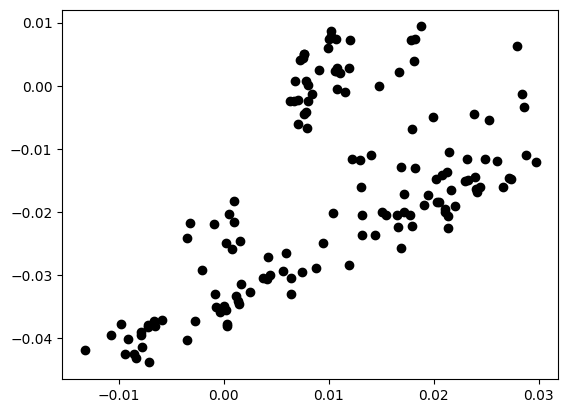

In [ ]:
#method_pca_entity_linkage(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), nComp=2)

##AE

In [ ]:
def method_ae_v0(ce_x, max_iter=10, loss=losses.MeanSquaredError(), epochs=10, inb_layer=300, bottleneck=100):
  emb_len = len(ce_x[0])
  iteration = 0;
  reconstruction_error_sum = np.zeros(shape=(len(ce_x),));

  #mms normalization
  scaler = MinMaxScaler(feature_range = (0,1))
  ce_x_scaled = scaler.fit_transform(ce_x)

  while (iteration < max_iter+1):
    #test train split
    ce_x_scaled_train, ce_x_scaled_test = train_test_split(ce_x_scaled, test_size=.2)

    #model
    #functional Keras annotation
    enc_input = tf.keras.Input(shape=(emb_len,), name="concat_all")
    enc_features = tf.keras.layers.Dense(inb_layer, activation='relu')(enc_input)
    enc_output = tf.keras.layers.Dense(bottleneck, activation='relu')(enc_features)
    encoder = tf.keras.Model(
        inputs=[enc_input],
        outputs=[enc_output],
        name="encoder")

    dec_input = tf.keras.Input(shape=(bottleneck,), name="decoder")
    dec_features = tf.keras.layers.Dense(bottleneck, activation='relu')(enc_output)
    dec_features = tf.keras.layers.Dense(inb_layer, activation='relu')(dec_features)
    dec_output = tf.keras.layers.Dense(emb_len, activation='relu', name="reconstructed")(dec_features)
    autoencoder = tf.keras.Model(
        inputs=[enc_input],
        outputs=[dec_output],
        name="autoencoder")

    #compile
    autoencoder.compile(optimizer='adam', loss=loss)

    #fit
    autoencoder.fit(
      {"concat_all": ce_x_scaled_train},
      {"reconstructed": ce_x_scaled_train},
      epochs=epochs,
      shuffle=True,
      verbose=0,
      validation_data=({"concat_all": ce_x_scaled_test}))

    #reconstruction
    reconstruction_error_sum = reconstruction_error_sum + tf.reduce_sum(
      (autoencoder({"concat_all": ce_x_scaled}) - ce_x_scaled)**2, axis=1)

    iteration = iteration + 1;

  return pd.DataFrame({ "reconstruction_error": reconstruction_error_sum }) #reconstruction_errors

In [ ]:
def method_ae_v1(ce_x):

  #mms normalization
  scaler = MinMaxScaler(feature_range = (0,1))
  ce_x_scaled = scaler.fit_transform(ce_x)

  #test train split
  ce_x_scaled_train, ce_x_scaled_test = train_test_split(ce_x_scaled, test_size=.1)

  #model
  #functional Keras annotation
  enc_table_input = tf.keras.Input(shape=(300,), name="table")
  enc_table_output = tf.keras.layers.Dense(100, activation='relu', name="enc_table_hidden_layer")(enc_table_input)
  enc_attr_input = tf.keras.Input(shape=(300,), name="attribute")
  enc_attr_output = tf.keras.layers.Dense(100, activation='relu', name="enc_attr_hidden_layer")(enc_attr_input)
  enc_attrmeta_input = tf.keras.Input(shape=(10,), name="attribute_meta")
  enc_concat_input = tf.keras.Input(shape=(100 + 100 + 10,), name="concat")
  enc_concat_features = tf.keras.layers.concatenate([enc_table_output, enc_attr_output, enc_attrmeta_input])
  enc_concat_output = tf.keras.layers.Dense(100, activation='relu', name="enc_concat_hidden_layer")(enc_concat_features)
  encoder = tf.keras.Model(
      inputs=[enc_table_input, enc_attr_input, enc_attrmeta_input],
      outputs=[enc_concat_output],
      name="encoder")

  dec_input = tf.keras.Input(shape=(100,), name="decoder")
  dec_features = tf.keras.layers.Dense(300, activation='relu')(enc_concat_output)
  dec_output = tf.keras.layers.Dense(610, activation='relu', name="reconstructed")(dec_features)
  autoencoder = tf.keras.Model(
      inputs=[enc_table_input, enc_attr_input, enc_attrmeta_input],
      outputs=[dec_output],
      name="autoencoder")

  #compile
  autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

  #fit
  autoencoder.fit(
    {"table": ce_x_scaled_train[:,0:300], "attribute": ce_x_scaled_train[:,300:600], "attribute_meta": ce_x_scaled_train[:,600:610]},
    {"reconstructed": ce_x_scaled_train},
    epochs=10,
    shuffle=True,
    validation_data=({"table": ce_x_scaled_test[:,0:300], "attribute": ce_x_scaled_test[:,300:600], "attribute_meta": ce_x_scaled_test[:,600:610]}))

  #reconstruction
  reconstruction_errors = tf.reduce_sum(
    (autoencoder({"table": ce_x_scaled[:,0:300], "attribute": ce_x_scaled[:,300:600], "attribute_meta": ce_x_scaled[:,600:610]}) - ce_x_scaled)**2,
    axis=1)

  return pd.DataFrame({ "reconstruction_error": reconstruction_errors }) #reconstruction_errors

#2.2 Scoping Framework

Prequisites p and matching sequence (blocking)

In [18]:
import itertools

In [19]:
def entity_collection_to_block(entity_collection, start_percentile, end_percentile):
  return entity_collection[(entity_collection.index>=np.percentile(entity_collection.index, start_percentile)) &
                           (entity_collection.index<=np.percentile(entity_collection.index, end_percentile))]

In [20]:
def entity_collection_to_dataframes(entity_collection):
  schemas = {}

  for schema_key in entity_collection.sort_values(by=['schema'], ascending=False)['schema'].unique():
    entity_collection_schema = entity_collection[entity_collection["schema"]== schema_key]
    entity_collection_table_key = entity_collection_schema['refined_local_name_p'].unique()

    schema = {}
    for table_key in entity_collection_table_key:
      entity_collection_table = entity_collection_schema[entity_collection_schema["refined_local_name_p"] == table_key]
      entity_collection_attribute_key = entity_collection_table['refined_local_name'].unique()
      schema[table_key] = pd.DataFrame(columns=entity_collection_attribute_key)

    schemas[schema_key] = schema

  return schemas;

In [28]:
#This function creates all possible matching sequences between schemas:
#The output includes SCHEMA1:customer:customernumber, SCHEMA2:client:clientid and
#                    SCHEMA2:client:clientid, SCHEMA1:customer:customernumber
def holistic_matching_sequence(entity_collection):
  mapping_sequence = []
  schema_key_curr = ""

  for schema_key_a, table_keys_a in entity_collection.items():
    schema_key_curr = schema_key_a #set current schema

    for table_key_a, attributes_df_a in table_keys_a.items():
      #extract df for each table_key

      for schema_key_b, table_keys_b in entity_collection.items():
        #loop through all schemas (again)
        if schema_key_curr == schema_key_b:
          #exclude schema_key_a
          continue
        else:
          for schema_key_b, attributes_df_b in table_keys_b.items():
            #cartesian product between table_a_columns and table_b_columns
            mapping_sequence = mapping_sequence + [matching for matching in itertools.product(attributes_df_a.columns.tolist(), attributes_df_b.columns.tolist())]

  return mapping_sequence


In [29]:
#This function creates all possible matching sequences between schemas:
#Limited to a_b order of the schema list
#It includes SCHEMA1:customer:customernumber, SCHEMA2:client:clientid
#But not     SCHEMA2:client:clientid, SCHEMA1:customer:customernumber
def holistic_matching_sequence_ab(entity_collection):
  mapping_sequence = []
  schema_key_curr = ""
  entity_collection_exlude = entity_collection.copy()

  for schema_key_a, table_keys_a in entity_collection.items():
    for table_key_a, attributes_df_a in table_keys_a.items():
      #extract df for each table_key

      for schema_key_b, table_keys_b in entity_collection_exlude.items():
        schema_key_curr = schema_key_a #set current schema
        #loop through all schemas (again)
        if schema_key_curr == schema_key_b:
          #exclude schema_key_a
          continue
        else:
          for schema_key_b, attributes_df_b in table_keys_b.items():
            #cartesian product between table_a_columns and table_b_columns
            mapping_sequence = mapping_sequence + [matching for matching in itertools.product(attributes_df_a.columns.tolist(), attributes_df_b.columns.tolist())]

    del entity_collection_exlude[schema_key_a]
  return mapping_sequence


In [30]:
#This function creates all possible matching sequences between schemas FASTER!
def holistic_matching_sequence_ab_n(entity_collection):
  schema_key_ignore = []
  mapping_sequence = []
  mapping_sequence_id = []

  for schema_key in sorted(entity_collection.schema.unique())[::-1]:
    schema_key_ignore.append(schema_key)
    comp_df = entity_collection[~entity_collection.schema.isin(schema_key_ignore)].reset_index(drop=True)
    if len(comp_df.index) > 0:
      for i, row_a in entity_collection[entity_collection.schema==schema_key].iterrows():
        for j, row_b in comp_df.iterrows():
          mapping_sequence.append((row_a.refined_local_name, row_b.refined_local_name))
          mapping_sequence_id.append((row_a.id, row_b.id))
  return mapping_sequence, mapping_sequence_id

In [ ]:
#df_tmp = df_OC_ORACLE_OC_MYSQL_OC_HANA.sort_values(by=["reconstruction_error_01ae_v0_sgtrt5_b10"]).reset_index(drop=True)
#df_tmp_block = entity_collection_to_block(df_tmp, 0, 30)

#print(len(holistic_matching_sequence_ab_n(df_tmp_block)[1]))
#print(len(holistic_matching_sequence_ab(entity_collection_to_dataframes(df_tmp_block))))

## 2.2.0 LSH

In [31]:
!apt install libomp-dev
!pip install faiss-cpu

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libomp-dev amd64 1:14.0-55~exp2 [3,074 B]
Fetched 738 kB in 1s (1,037 kB/s)
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a

In [32]:
import faiss

In [33]:
def lsh_matching_sequence(entity_collection, k=50):
  schema_key_ignore = []
  mapping_sequence = []
  mapping_sequence_id = []
  model = SentenceTransformer('sentence-transformers/gtr-t5-base')

  for schema_key in sorted(entity_collection.schema.unique())[::-1]:
    schema_key_ignore.append(schema_key)
    comp_df = entity_collection[~entity_collection.schema.isin(schema_key_ignore)].reset_index(drop=True)
    if len(comp_df.index) > 0:
      comp_ce = concept_embeddings_to_ce_x(df_toEmbeddings(comp_df), "sgtrt5")
      len_vector = len(comp_ce[0]) #Print 768
      index = faiss.IndexFlatL2(len_vector)
      index.add(np.asarray(comp_ce))
      k = k
      for i, row in entity_collection[entity_collection.schema==schema_key].iterrows():
        q = model.encode(row.concept_concat_sgtrt5)
        D, I = index.search(np.asarray([q]), k)
        for item_pair in I[0]:
          if(item_pair!=-1):
            mapping_sequence.append((row.refined_local_name, comp_df.iloc[item_pair].refined_local_name))
            mapping_sequence_id.append((row.id, comp_df.iloc[item_pair].id))
  return mapping_sequence, mapping_sequence_id

In [ ]:
sorted(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.schema.unique())[::-1]

['OC_ORACLE', 'OC_MYSQL', 'OC_HANA', 'HR_ORACLE']

##2.2.1 Time Complexity Evaluation

Reduction in number of pairwise comparisons in B vs brute-force approach (cartesian product between all entity profiles).

= 1 − ||B|| / ||E||


In [34]:
def reduction_ratio(df_entity_profiles, reconstruction_error="reconstruction_error_pca", interval=10):
  rr_plot = []
  b_plot = []
  E = len(holistic_matching_sequence_ab_n(df_entity_profiles)[1])
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    B = len(holistic_matching_sequence_ab_n(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval))[1])
    result = 1-(B/E)
    #print("RR Blocking " + str((i+1)*interval) + "% (lowest) MSE: 1 - (||B||=" + str(B) + " / ||E||=" + str(E) + ") = " + str(result))
    rr_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, rr_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Reduction Ratio (RR)',  title='MSE Blocking with')
  #ax.grid()
  #plt.show()
  return rr_plot;

In [ ]:
#reduction_ratio(df_OC_ORACLE_OC_MYSQL_OC_HANA,"reconstruction_error_01ae_v0_sgtrt5_b10")

[0.9897234396252078,
 0.9594982620522896,
 0.9102312226084328,
 0.8405621883028562,
 0.7494332779205077,
 0.6385068762278978,
 0.5076318573371619,
 0.36043524255705006,
 0.18996524104579116,
 0.0]

##2.2.2 Ground Truth

In [35]:
#Leo: These paths should only work for Leo
df_gt_mappings = pd.read_csv(r'/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/GROUNDTRUTH/AdjacencyList.csv', sep=";")

In [ ]:
df_gt_mappings

Attribute_A  Attribute_B  Bool      Cannonical_Name       Type  \
0    CONCEPT_45   CONCEPT_96     1             Customer      Table   
1    CONCEPT_45  CONCEPT_164     1             Customer      Table   
2    CONCEPT_96  CONCEPT_164     1             Customer      Table   
3    CONCEPT_46   CONCEPT_97     1          Customer ID  Attribute   
4    CONCEPT_46  CONCEPT_165     1          Customer ID  Attribute   
..          ...          ...   ...                  ...        ...   
74  CONCEPT_127   CONCEPT_12     1           Office ZIP  Attribute   
75  CONCEPT_121   CONCEPT_13     1     Office City Name  Attribute   
76  CONCEPT_125   CONCEPT_14     1    Office State Name  Attribute   
77  CONCEPT_126    CONCEPT_7     1  Office Country Name  Attribute   
78  CONCEPT_128    CONCEPT_4     1   Office Region Name  Attribute   

       Schemas_Mapping  Degree Add_Denormalization_Map Add_Concept_Name  
0   OC_ORACLE-OC_MYSQL       3                     NaN              NaN  
1    OC_ORACLE-OC_HANA       3                     NaN              NaN  
2     OC_MYSQL-OC_HANA       3                     NaN              NaN  
3   OC_ORACLE-OC_MYSQL       3                     NaN              NaN  
4    OC_ORACLE-OC_HANA       3                     NaN              NaN  
..                 ...     ...                     ...              ...  
74  HR_ORACLE-OC_MYSQL       3                     NaN              NaN  
75  HR_ORACLE-OC_MYSQL       3                     NaN              NaN  
76  HR_ORACLE-OC_MYSQL       3                     NaN              NaN  
77  HR_ORACLE-OC_MYSQL       3                     NaN              NaN  
78  HR_ORACLE-OC_MYSQL       3                     NaN              NaN  

[79 rows x 9 columns]

In [36]:
# GROUND TRUTH ORDERING CUSTOMER
gt_OC_ORACLE_OC_MYSQL_OC_HANA = []

for index, row in df_gt_mappings[(df_gt_mappings["Type"] == "Attribute") & (df_gt_mappings["Schemas_Mapping"].str.contains("HR_ORACLE")==False)].iterrows():
    #print(dfattrFullEmb_train[dfattrFullEmb_train["id"]==row['Attribute_A']].refined_local_name.item(),
    #      dfattrFullEmb_train[dfattrFullEmb_train["id"]==row['Attribute_B']].refined_local_name.item())
    gt_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].refined_local_name.item(),
                                          df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].refined_local_name.item()))

In [37]:
# GROUND TRUTH ORDERING CUSTOMER
gt_id_OC_ORACLE_OC_MYSQL_OC_HANA = []

for index, row in df_gt_mappings[(df_gt_mappings["Type"] == "Attribute") & (df_gt_mappings["Schemas_Mapping"].str.contains("HR_ORACLE")==False)].iterrows():
    #print(dfattrFullEmb_train[dfattrFullEmb_train["id"]==row['Attribute_A']].refined_local_name.item(),
    #      dfattrFullEmb_train[dfattrFullEmb_train["id"]==row['Attribute_B']].refined_local_name.item())
    gt_id_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].id.item(),
                                             df_OC_ORACLE_OC_MYSQL_OC_HANA[df_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].id.item()))

##2.2.3 Recall / Pair Completeness (PC)

Portion of detectable duplicates in a block with respect to all in E.

= |D(B)| / |D(E)|

In [38]:
def pair_completeness(df_entity_profiles, reconstruction_error, ground_truth, interval=10):
  pc_plot = []
  b_plot = []
  D_E = len(ground_truth)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    D_B = 0
    potential_matchings = holistic_matching_sequence_ab_n(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval))[1]
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    result = D_B / D_E
    #print("PC Blocking " + str((i+1)*interval) + "% (lowest) MSE: (||D(B)||=" + str(D_B) + " / ||D(E)||=" + str(D_E) + ") = " + str(result))
    pc_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, pc_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Pair Completeness (PC)',  title='MSE Blocking with ')
  #ax.grid()
  #plt.show()

  return pc_plot;

In [ ]:
#pair_completeness(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

[0.0851063829787234,
 0.2553191489361702,
 0.40425531914893614,
 0.574468085106383,
 0.6382978723404256,
 0.7446808510638298,
 0.9148936170212766,
 1.0,
 1.0,
 1.0]

###LSH (RR+PC)

In [39]:
def reduction_ratio_lsh(df_entity_profiles, reconstruction_error="reconstruction_error_pca", interval=10, k=50):
  rr_plot = []
  b_plot = []
  E = len(holistic_matching_sequence_ab_n(df_entity_profiles)[1])
  #print(E)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    B = len(lsh_matching_sequence(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval))[1])
    #print(B)
    result = 1-(B/E)
    #print("RR Blocking " + str((i+1)*interval) + "% (lowest) MSE: 1 - (||B||=" + str(B) + " / ||E||=" + str(E) + ") = " + str(result))
    rr_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, rr_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Reduction Ratio (RR)',  title='MSE Blocking with')
  #ax.grid()
  plt.show()
  return rr_plot;

In [ ]:
#reduction_ratio_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA,"reconstruction_error_01ae_v0_sgtrt5_b10")

[0.9897234396252078,
 0.9594982620522896,
 0.9102312226084328,
 0.8405621883028562,
 0.7494332779205077,
 0.6784041106241498,
 0.5937736134199789,
 0.5103521233187245,
 0.41363155508538607,
 0.31842224573069366]

In [40]:
def pair_completeness_lsh(df_entity_profiles, reconstruction_error, ground_truth, interval=10, k=50):
  pc_plot = []
  b_plot = []
  D_E = len(ground_truth)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    D_B = 0
    potential_matchings = lsh_matching_sequence(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval), k=k)[1]
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    result = D_B / D_E
    #print("PC Blocking " + str((i+1)*interval) + "% (lowest) MSE: (||D(B)||=" + str(D_B) + " / ||D(E)||=" + str(D_E) + ") = " + str(result))
    pc_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, pc_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Pair Completeness (PC)',  title='MSE Blocking with ')
  #ax.grid()
  #plt.show()

  return pc_plot;

In [ ]:
#pair_completeness_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

[0.0851063829787234,
 0.2553191489361702,
 0.40425531914893614,
 0.574468085106383,
 0.6382978723404256,
 0.7446808510638298,
 0.9148936170212766,
 1.0,
 1.0,
 1.0]

In [41]:
def rr_pc_lsh(df_entity_profiles, reconstruction_error, ground_truth, interval=10, k=50):
  rr_plot = []
  pc_plot = []
  b_plot = []
  E = len(holistic_matching_sequence_ab_n(df_entity_profiles)[1])
  D_E = len(ground_truth)
  #print(E)
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    b_plot.append(((i+1)*interval))
    #PC
    D_B = 0
    potential_matchings = lsh_matching_sequence(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval), k=k)[1]
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    result_pc = D_B / D_E
    pc_plot.append(result_pc)
    ##RR
    B = len(potential_matchings)
    result_rr = 1-(B/E)
    rr_plot.append(result_rr)

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, rr_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Reduction Ratio (RR)',  title='MSE Blocking with')
  #ax.grid()
  plt.show()
  return rr_plot, pc_plot;

##2.2.4 Precision / Pairs Quality (PQ)

Portion of comparisons in a block with respect to real duplicates in B.

= |D(B)| / ||B||

In [42]:
def pair_quality(df_entity_profiles, reconstruction_error, ground_truth, interval=10):
  pq_plot = []
  b_plot = []
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    D_B = 0
    potential_matchings = holistic_matching_sequence_ab_n(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval))[1]
    B = len(potential_matchings)
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    if(B==0):
      result=0
    else:
      result = D_B / B
    if(result > 1):
      result = 1
    #print("PQ Blocking " + str((i+1)*interval) + "% (lowest) MSE: (||D(B)||=" + str(D_B) + " / ||B||=" + str(B) + ") = " + str(result))
    pq_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, pq_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Pair Quality (PQ)',  title='MSE Blocking with ')
  #ax.grid()
  #plt.show()

  return pq_plot;

In [ ]:
#pair_quality(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_glove", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

[0.1388888888888889,
 0.05555555555555555,
 0.030852994555353903,
 0.02328159645232816,
 0.016600265604249667,
 0.011925795053003533,
 0.0103125,
 0.008034026465028356,
 0.007358490566037735,
 0.007102916729635787]

###LSH

In [43]:
def pair_quality_lsh(df_entity_profiles, reconstruction_error, ground_truth, interval=10, k=50):
  pq_plot = []
  b_plot = []
  df_entity_profiles_MSE_sorted = df_entity_profiles.sort_values(by=[reconstruction_error]).reset_index(drop=True)
  for i in range((int(100/interval))):
    D_B = 0
    potential_matchings = lsh_matching_sequence(entity_collection_to_block(df_entity_profiles_MSE_sorted, 0, (i+1)*interval), k=k)[1]
    B = len(potential_matchings)
    for matching in ground_truth:
      if matching in potential_matchings:
        D_B += 1
    if(B==0):
      result=0
    else:
      result = D_B / B
    if(result > 1):
      result = 1
    #print("PQ Blocking " + str((i+1)*interval) + "% (lowest) MSE: (||D(B)||=" + str(D_B) + " / ||B||=" + str(B) + ") = " + str(result))
    pq_plot.append(result)
    b_plot.append(((i+1)*interval))

  #create plot
  #fig, ax = plt.subplots()
  #ax.plot(b_plot, pq_plot)
  #ax.set(xlabel='Blocking Range in %', ylabel='Pair Quality (PQ)',  title='MSE Blocking with ')
  #ax.grid()
  #plt.show()

  return pq_plot;

In [ ]:
#pair_quality_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_glove", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA, interval=10)

[0.1388888888888889,
 0.05555555555555555,
 0.030852994555353903,
 0.02328159645232816,
 0.0178826895565093,
 0.013775510204081633,
 0.012692307692307692,
 0.010493827160493827,
 0.010182767624020888,
 0.010421286031042129]

##2.2.5 Performance AUC and plot

In [44]:
def performance_plot(df, eval_col, gt):
  plt.rcParams['figure.figsize'] = [8, 6]
  plot_pc = pair_completeness(df, eval_col, gt, interval=1)
  #plot_pq = pair_quality(df_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_OC_ORACLE_OC_MYSQL_OC_HANA, interval=1)
  plot_rr = reduction_ratio(df, eval_col, interval=1)
  #M: RR x PC
  #plot_m = [rr*pc for rr, pc in zip(plot_rr, plot_pc)]
  #HM: 2 x (RR x PC) / (RR + PC)
  plot_hm = [2*(rr*pc)/(rr+pc) for rr, pc in zip(plot_rr, plot_pc)]

  #create plot
  fig, ax = plt.subplots()
  ax.plot(np.arange(0,100).tolist(), plot_pc, label = "PC")
  #ax.plot(np.arange(0,100).tolist(), plot_pq, label = "PQ")
  ax.plot(np.arange(0,100).tolist(), plot_rr, label = "RR")
  #ax.plot(np.arange(0,100).tolist(), plot_m, label = "M(RR,PC)")
  ax.plot(np.arange(0,100).tolist(), plot_hm, label = "HM(RR,PC)")

  ax.set(xlabel='Scoping Range in % (p)', ylabel='Performance',  title='Scoping with R(V('+eval_col+'))')
  ax.grid()
  plt.legend()
  plt.show()

  # Compute the area using the composite trapezoidal rule.
  auc_pc_trapezoidal = trapz(plot_pc, dx=1)
  auc_hm_trapezoidal = trapz(plot_hm, dx=1)
  print("AUC PC (trapezoidal rule): ", auc_pc_trapezoidal)
  print("AUC HM (trapezoidal rule): ", auc_hm_trapezoidal)
  # Compute the area using the composite Simpson's rule.
  #auc_pc_simpson = simpson(plot_pc, dx=1)
  #auc_hm_simpson = simpson(plot_hm, dx=1)
  #print("AUC PC (Simpson's rule): ", auc_hm_simpson)
  #print("AUC HM (Simpson's rule): ", auc_hm_simpson)

  return [eval_col, auc_pc_trapezoidal, auc_hm_trapezoidal]

In [45]:
def performance_plot_lsh(df, eval_col, gt, interval=1, k=50):
  plt.rcParams['figure.figsize'] = [8, 6]
  plot_rr, plot_pc = rr_pc_lsh(df, eval_col, gt, interval=interval, k=k)
  #plot_pc = pair_completeness_lsh(df, eval_col, gt, interval=interval, k=k)
  #plot_pq = pair_quality(df_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_OC_ORACLE_OC_MYSQL_OC_HANA, interval=1)
  #plot_rr = reduction_ratio_lsh(df, eval_col, interval=interval, k=k)
  #M: RR x PC
  #plot_m = [rr*pc for rr, pc in zip(plot_rr, plot_pc)]
  #HM: 2 x (RR x PC) / (RR + PC)
  plot_hm = [2*(rr*pc)/(rr+pc) for rr, pc in zip(plot_rr, plot_pc)]

  #create plot
  fig, ax = plt.subplots()
  ax.plot(np.arange(0,100).tolist(), plot_pc, label = "PC")
  #ax.plot(np.arange(0,100).tolist(), plot_pq, label = "PQ")
  ax.plot(np.arange(0,100).tolist(), plot_rr, label = "RR")
  #ax.plot(np.arange(0,100).tolist(), plot_m, label = "M(RR,PC)")
  ax.plot(np.arange(0,100).tolist(), plot_hm, label = "HM(RR,PC)")

  ax.set(xlabel='Scoping Range in % (p)', ylabel='Performance',  title='Scoping with R(V('+eval_col+'))')
  ax.grid()
  plt.legend()
  plt.show()

  # Compute the area using the composite trapezoidal rule.
  auc_pc_trapezoidal = trapz(plot_pc, dx=1)
  auc_hm_trapezoidal = trapz(plot_hm, dx=1)
  print("AUC PC (trapezoidal rule): ", auc_pc_trapezoidal)
  print("AUC HM (trapezoidal rule): ", auc_hm_trapezoidal)
  # Compute the area using the composite Simpson's rule.
  #auc_pc_simpson = simpson(plot_pc, dx=1)
  #auc_hm_simpson = simpson(plot_hm, dx=1)
  #print("AUC PC (Simpson's rule): ", auc_hm_simpson)
  #print("AUC HM (Simpson's rule): ", auc_hm_simpson)

  return [eval_col, auc_pc_trapezoidal, auc_hm_trapezoidal]

#2.3 Scoping Evaluation (domain-specific)

In [ ]:
#df_OC_ORACLE_OC_MYSQL_OC_HANA.to_csv("/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/df_OC_ORACLE_OC_MYSQL_OC_HANA.csv", index=False)

In [46]:
df_OC_ORACLE_OC_MYSQL_OC_HANA = pd.read_csv(r'/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/df_OC_ORACLE_OC_MYSQL_OC_HANA.csv')

In [ ]:
#eval_columns = ["reconstruction_error_pca2_glove","reconstruction_error_pca5_glove","reconstruction_error_pca2_sgtrt5","reconstruction_error_pca5_sgtrt5","reconstruction_error_01pca2_glove","reconstruction_error_01pca5_glove","reconstruction_error_01pca40_glove","reconstruction_error_01pca2_sgtrt5","reconstruction_error_01pca5_sgtrt5","reconstruction_error_01pca55_sgtrt5","reconstruction_error_01ae_v0_glove","reconstruction_error_01ae_v0_sgtrt5"]
#eval_columns_baseline = ["reconstruction_error_lof_glove","reconstruction_error_01lof_glove","reconstruction_error_lof_sgtrt5","reconstruction_error_01lof_sgtrt5","reconstruction_error_zscore_sgtrt5","reconstruction_error_zscore_glove"]

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_glove"] =  method_zscore(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"))
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5"] = method_zscore(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"))
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5dc"] = method_zscore(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"))

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5"] = method_clf(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_glove"] =  method_clf(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"), min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5dc"] = method_clf(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), min_max_scale=True)

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_glove"], _ = method_pca(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"), 2, min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5"], _ = method_pca(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), 2, min_max_scale=True)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5dc"], _ = method_pca(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), 2, min_max_scale=True)

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=20, bottleneck=10)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=20, bottleneck=10)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=10)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b25"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=20, bottleneck=25)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b25"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=20, bottleneck=25)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b25"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=25)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b50"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=20, bottleneck=50)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b50"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=20, bottleneck=50)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b50"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=50)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b100"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=20, bottleneck=100)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b100"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=20, bottleneck=100)
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b100"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=20, bottleneck=100)

In [ ]:
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_MSLE"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=10, loss=losses.MeanSquaredLogarithmicError())
#df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_MAPE"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=10, loss=losses.MeanAbsolutePercentageError())
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_Poisson"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=10, loss=losses.Poisson())
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_MAE"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=10, loss=losses.MeanAbsoluteError())
#df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_KLD"] = method_ae_v0(concept_embeddings_to_ce_x(ce_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), max_iter=50, bottleneck=10, loss=losses.KLDivergence())

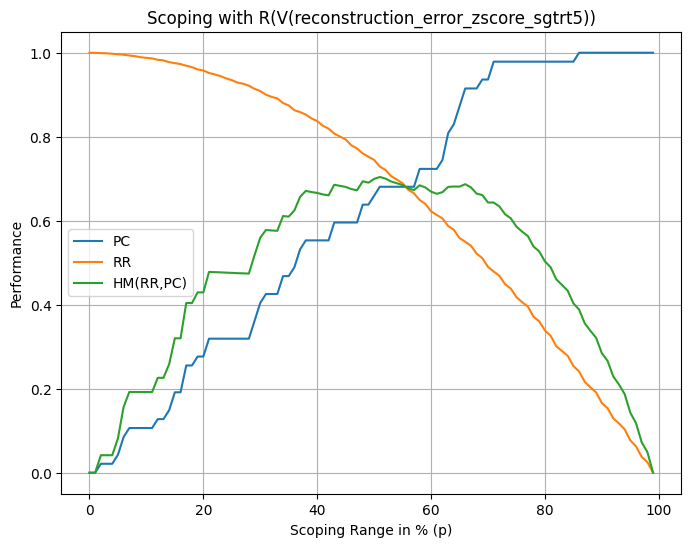

AUC PC (trapezoidal rule):  60.52127659574469
AUC HM (trapezoidal rule):  46.822966563472264


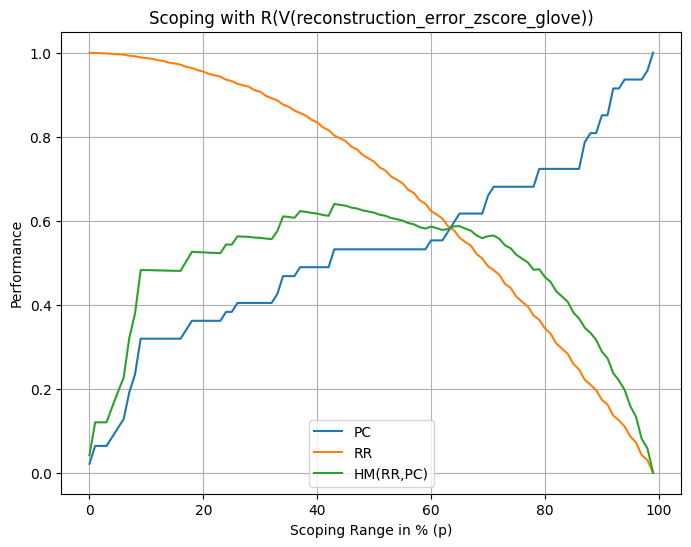

AUC PC (trapezoidal rule):  52.361702127659576
AUC HM (trapezoidal rule):  47.30204281040973


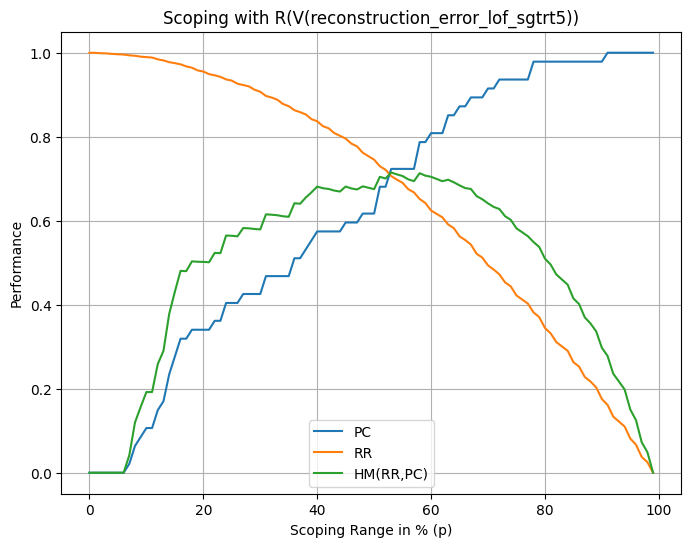

AUC PC (trapezoidal rule):  61.58510638297872
AUC HM (trapezoidal rule):  48.19251176198103


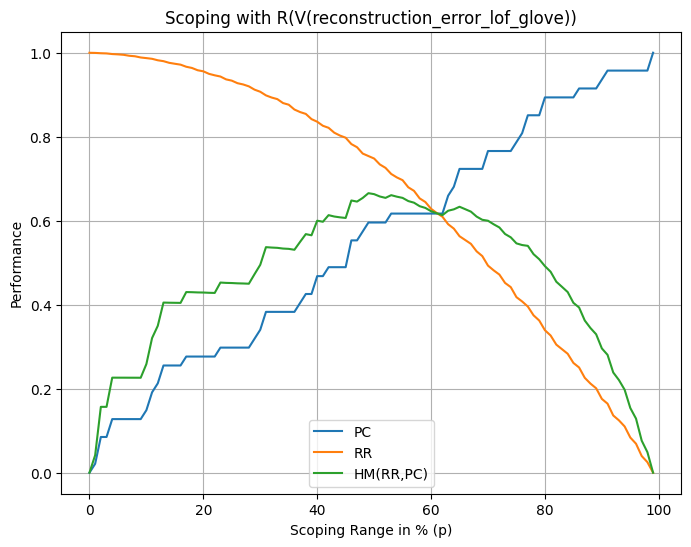

AUC PC (trapezoidal rule):  54.37234042553192
AUC HM (trapezoidal rule):  45.68637759938844


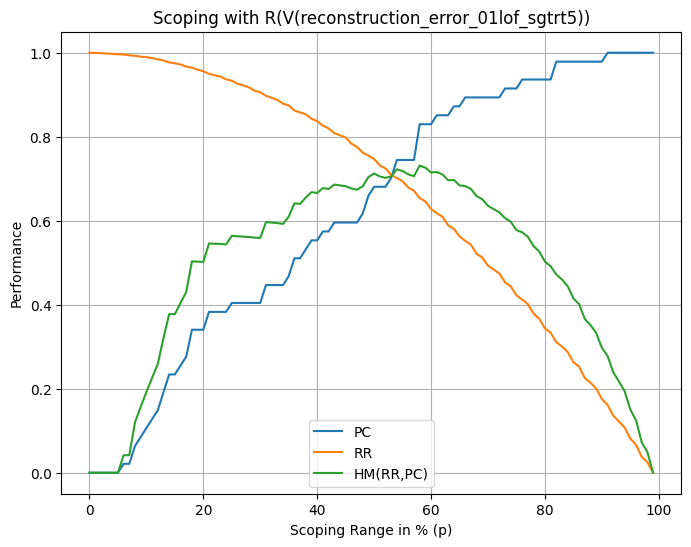

AUC PC (trapezoidal rule):  61.5
AUC HM (trapezoidal rule):  48.15897834267764


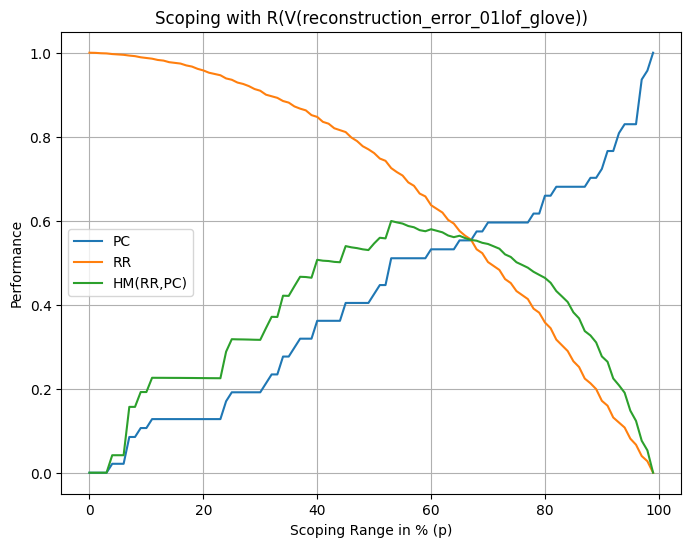

AUC PC (trapezoidal rule):  40.861702127659576
AUC HM (trapezoidal rule):  36.86168164205713


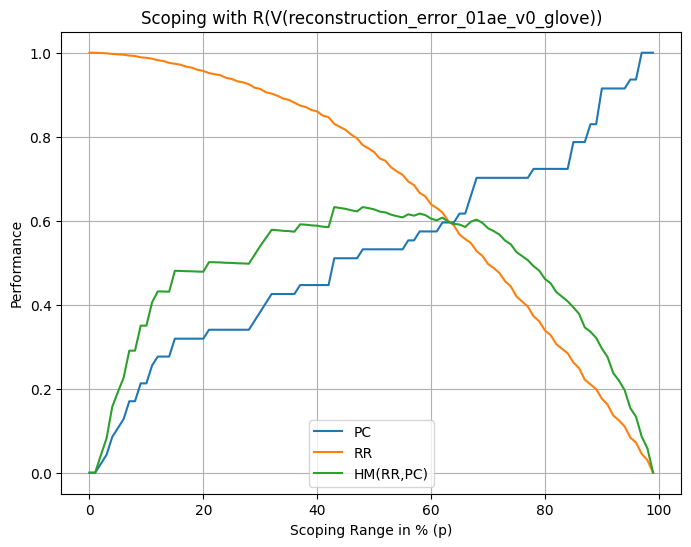

AUC PC (trapezoidal rule):  51.776595744680854
AUC HM (trapezoidal rule):  46.06006608980064


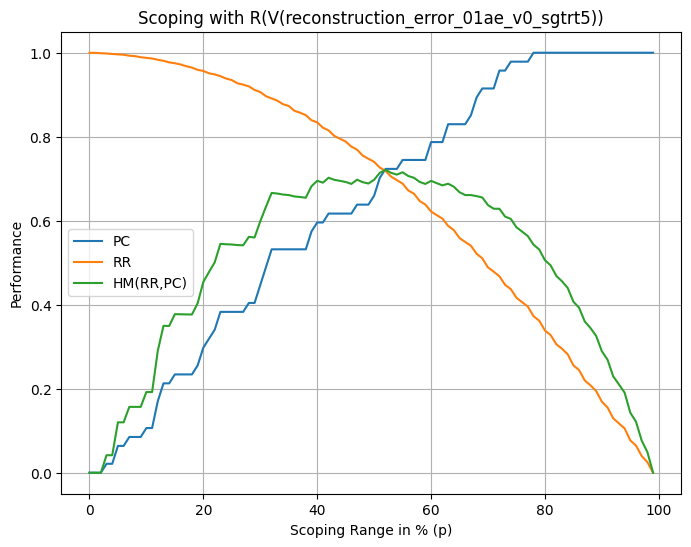

AUC PC (trapezoidal rule):  62.287234042553195
AUC HM (trapezoidal rule):  48.30354935329519


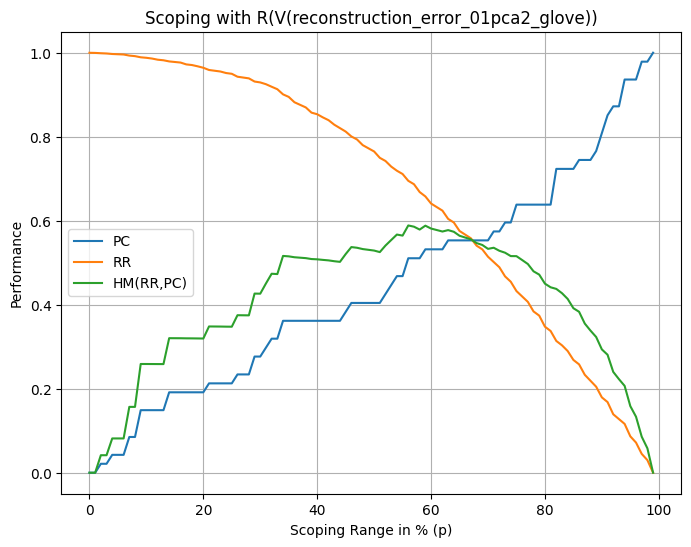

AUC PC (trapezoidal rule):  43.73404255319149
AUC HM (trapezoidal rule):  39.57387264561551


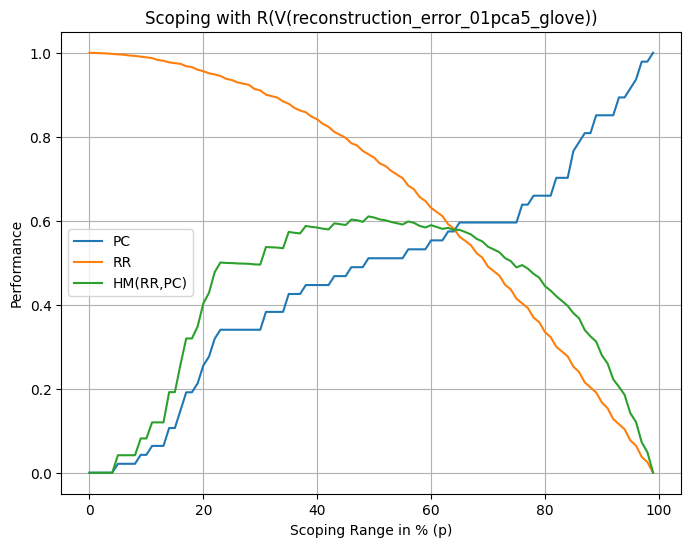

AUC PC (trapezoidal rule):  46.56382978723405
AUC HM (trapezoidal rule):  40.65860579920272


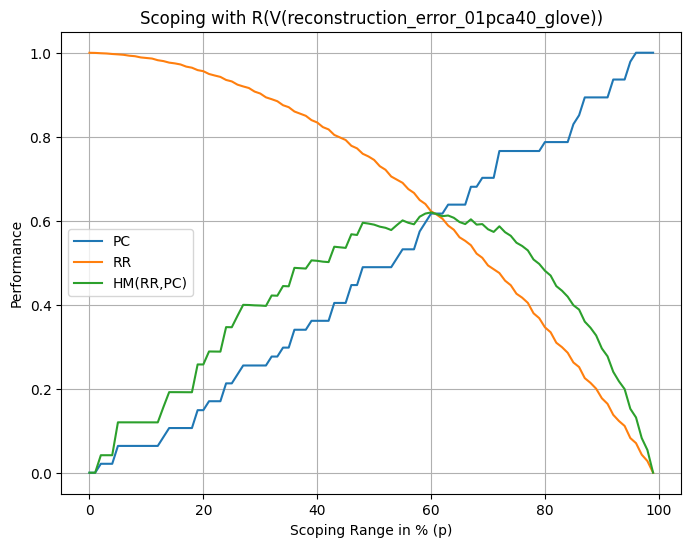

AUC PC (trapezoidal rule):  47.244680851063826
AUC HM (trapezoidal rule):  38.97585647555903


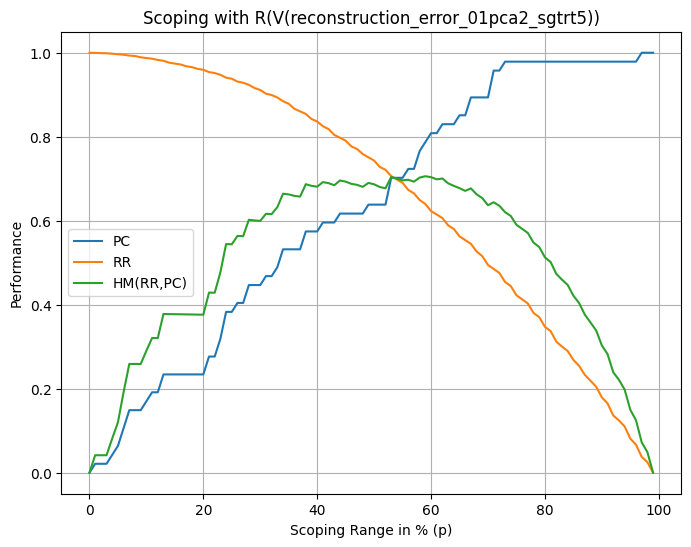

AUC PC (trapezoidal rule):  62.03191489361703
AUC HM (trapezoidal rule):  49.02383124491269


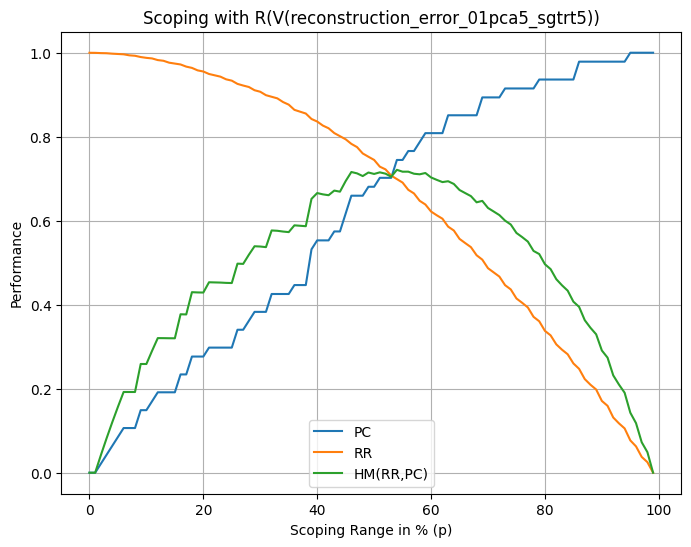

AUC PC (trapezoidal rule):  60.26595744680852
AUC HM (trapezoidal rule):  47.515885277814725


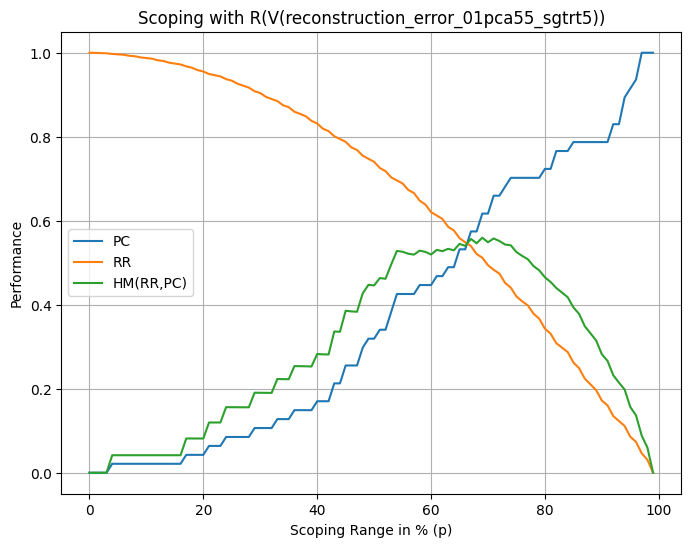

AUC PC (trapezoidal rule):  36.9468085106383
AUC HM (trapezoidal rule):  29.273423957343667


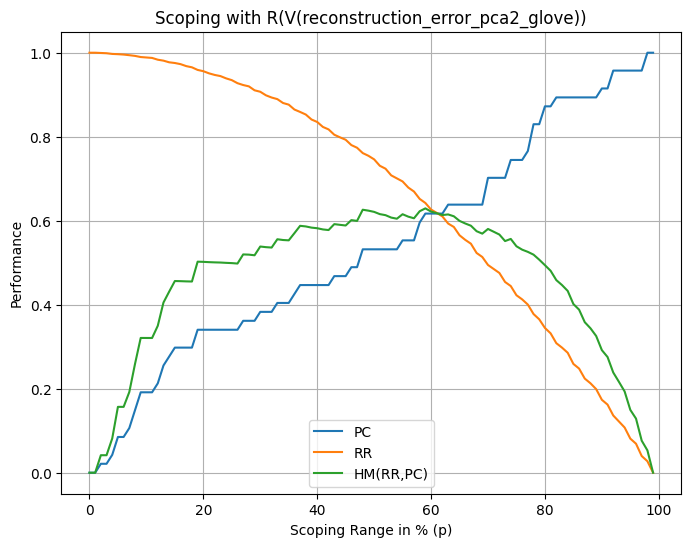

AUC PC (trapezoidal rule):  53.03191489361702
AUC HM (trapezoidal rule):  45.38309123003888


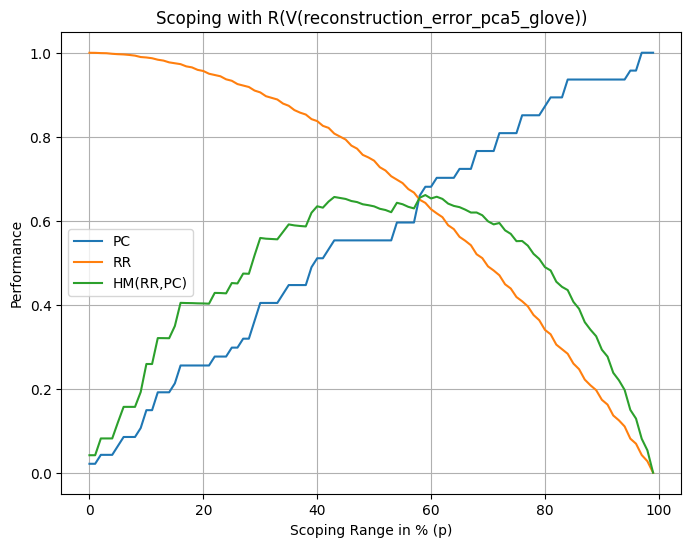

AUC PC (trapezoidal rule):  54.93617021276596
AUC HM (trapezoidal rule):  45.288937136736166


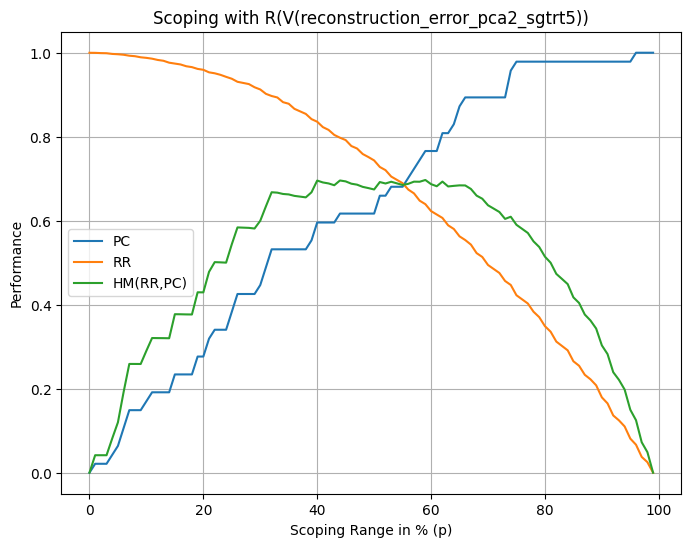

AUC PC (trapezoidal rule):  61.797872340425535
AUC HM (trapezoidal rule):  49.0574046143302


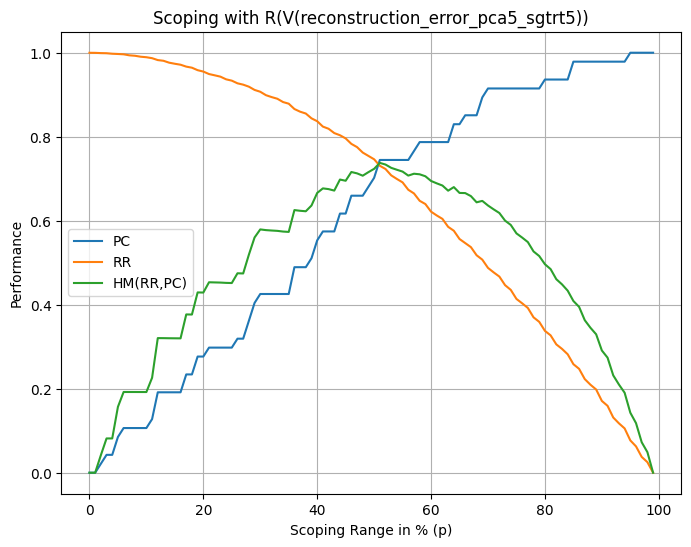

AUC PC (trapezoidal rule):  60.308510638297875
AUC HM (trapezoidal rule):  47.386503537323364


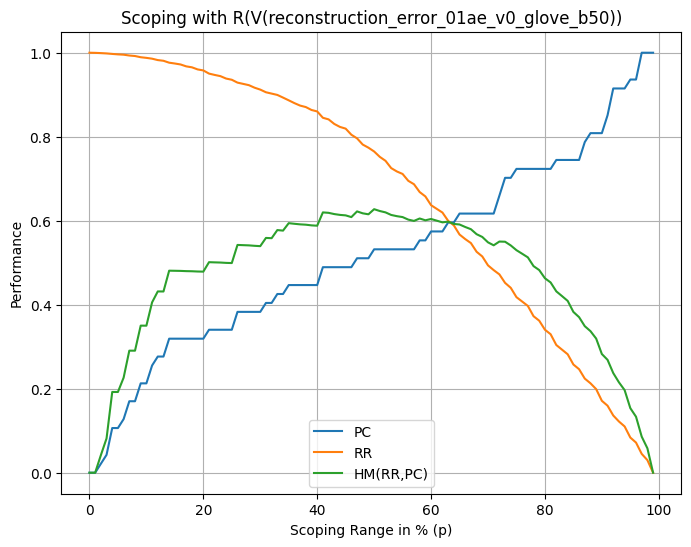

AUC PC (trapezoidal rule):  51.26595744680852
AUC HM (trapezoidal rule):  46.038645613986695


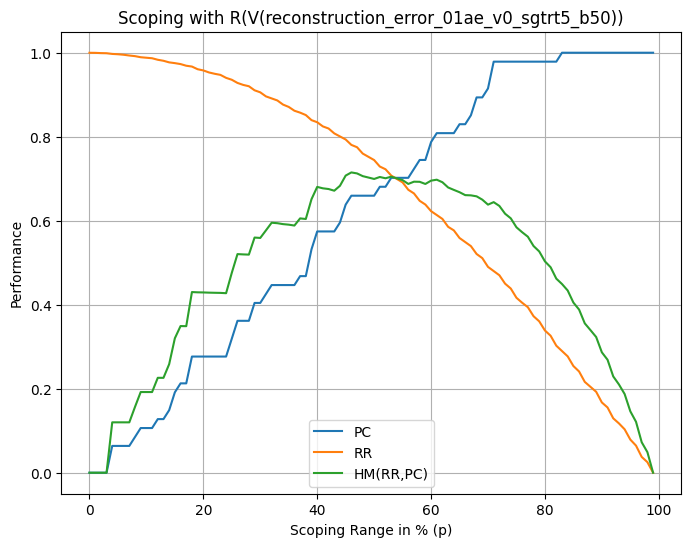

AUC PC (trapezoidal rule):  60.64893617021277
AUC HM (trapezoidal rule):  46.776684863575


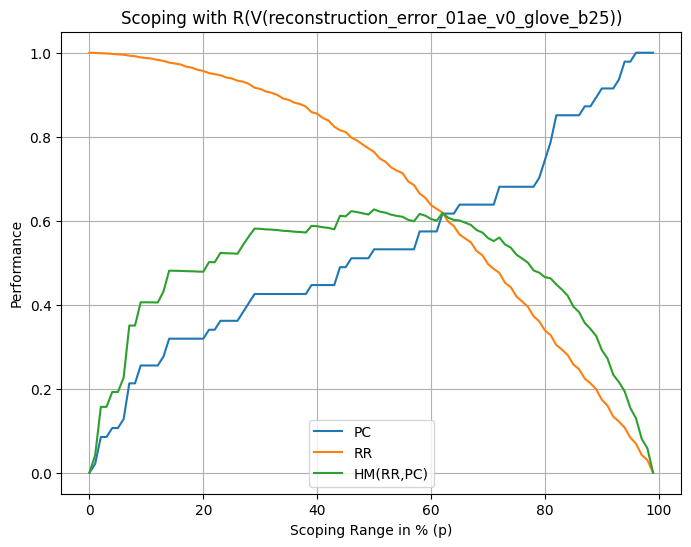

AUC PC (trapezoidal rule):  52.819148936170215
AUC HM (trapezoidal rule):  46.66718088369849


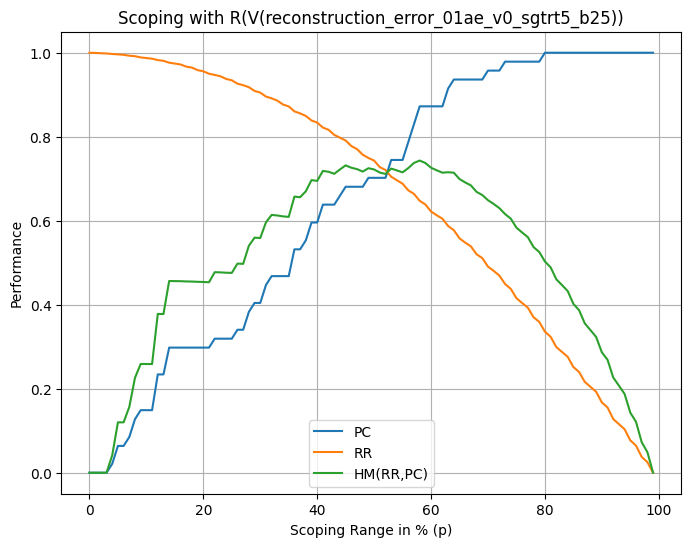

AUC PC (trapezoidal rule):  64.01063829787233
AUC HM (trapezoidal rule):  49.173243974156094


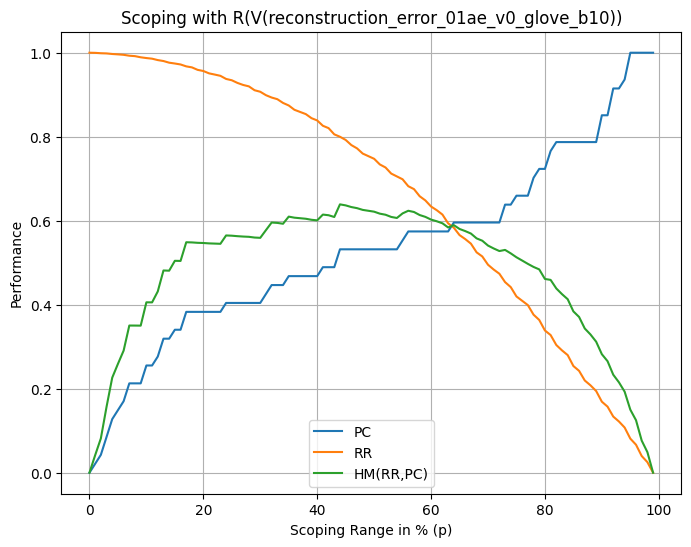

AUC PC (trapezoidal rule):  52.69148936170213
AUC HM (trapezoidal rule):  47.32972398467269


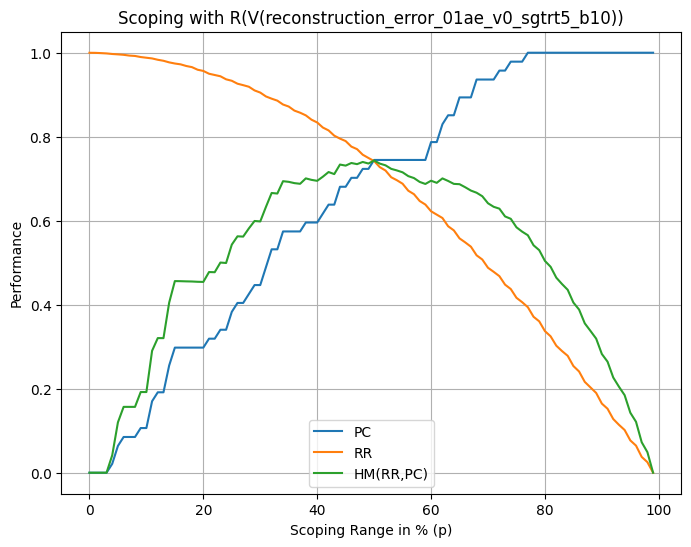

AUC PC (trapezoidal rule):  64.0531914893617
AUC HM (trapezoidal rule):  49.45416800039178


Setting  AUC_PC_trapezoidal  \
0        reconstruction_error_zscore_sgtrt5           60.521277   
1         reconstruction_error_zscore_glove           52.361702   
2           reconstruction_error_lof_sgtrt5           61.585106   
3            reconstruction_error_lof_glove           54.372340   
4         reconstruction_error_01lof_sgtrt5           61.500000   
5          reconstruction_error_01lof_glove           40.861702   
6        reconstruction_error_01ae_v0_glove           51.776596   
7       reconstruction_error_01ae_v0_sgtrt5           62.287234   
8         reconstruction_error_01pca2_glove           43.734043   
9         reconstruction_error_01pca5_glove           46.563830   
10       reconstruction_error_01pca40_glove           47.244681   
11       reconstruction_error_01pca2_sgtrt5           62.031915   
12       reconstruction_error_01pca5_sgtrt5           60.265957   
13      reconstruction_error_01pca55_sgtrt5           36.946809   
14          reconstruction_error_pca2_glove           53.031915   
15          reconstruction_error_pca5_glove           54.936170   
16         reconstruction_error_pca2_sgtrt5           61.797872   
17         reconstruction_error_pca5_sgtrt5           60.308511   
18   reconstruction_error_01ae_v0_glove_b50           51.265957   
19  reconstruction_error_01ae_v0_sgtrt5_b50           60.648936   
20   reconstruction_error_01ae_v0_glove_b25           52.819149   
21  reconstruction_error_01ae_v0_sgtrt5_b25           64.010638   
22   reconstruction_error_01ae_v0_glove_b10           52.691489   
23  reconstruction_error_01ae_v0_sgtrt5_b10           64.053191   

    AUC_HM_trapezoidal  
0            46.822967  
1            47.302043  
2            48.192512  
3            45.686378  
4            48.158978  
5            36.861682  
6            46.060066  
7            48.303549  
8            39.573873  
9            40.658606  
10           38.975856  
11           49.023831  
12           47.515885  
13           29.273424  
14           45.383091  
15           45.288937  
16           49.057405  
17           47.386504  
18           46.038646  
19           46.776685  
20           46.667181  
21           49.173244  
22           47.329724  
23           49.454168

In [ ]:
auc = []
for eval_col in df_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]:
  auc.append(performance_plot(df_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_id_OC_ORACLE_OC_MYSQL_OC_HANA))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

###LSH

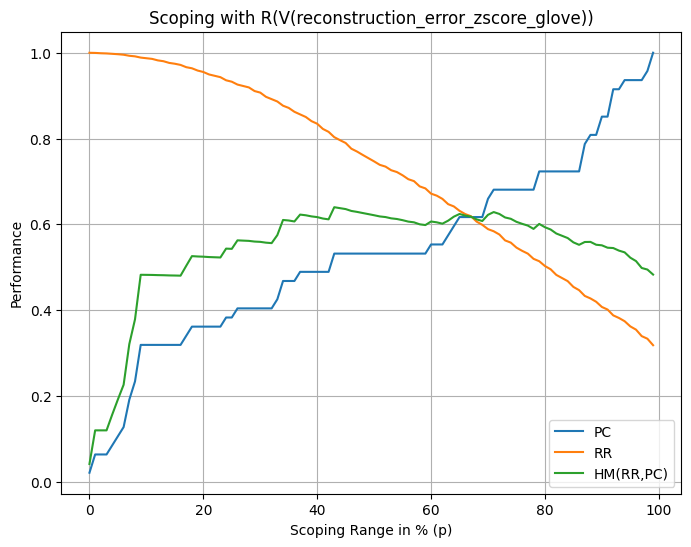

AUC PC (trapezoidal rule):  52.361702127659576
AUC HM (trapezoidal rule):  53.687655447420994


['reconstruction_error_zscore_glove', 52.361702127659576, 53.687655447420994]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_zscore_glove", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

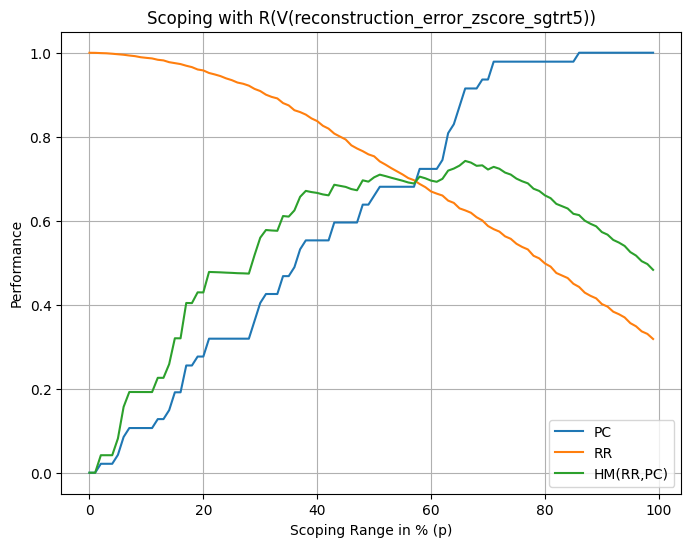

AUC PC (trapezoidal rule):  60.52127659574469
AUC HM (trapezoidal rule):  54.10529022881965


In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_zscore_sgtrt5", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

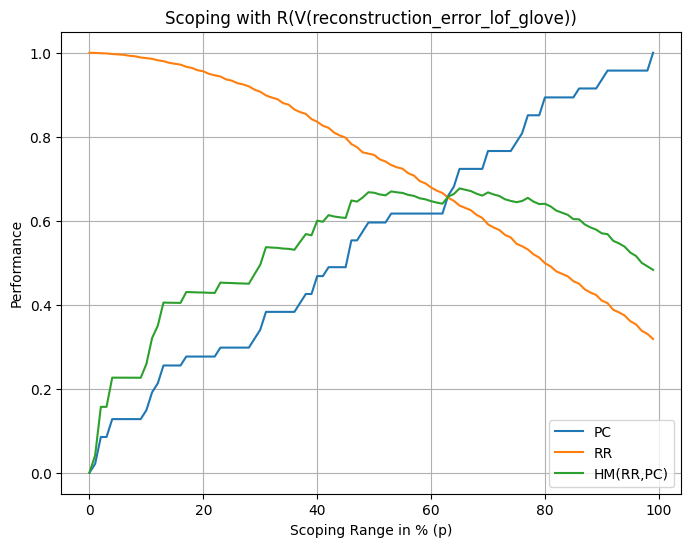

AUC PC (trapezoidal rule):  54.37234042553192
AUC HM (trapezoidal rule):  52.52524079350973


['reconstruction_error_lof_glove', 54.37234042553192, 52.52524079350973]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_lof_glove", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

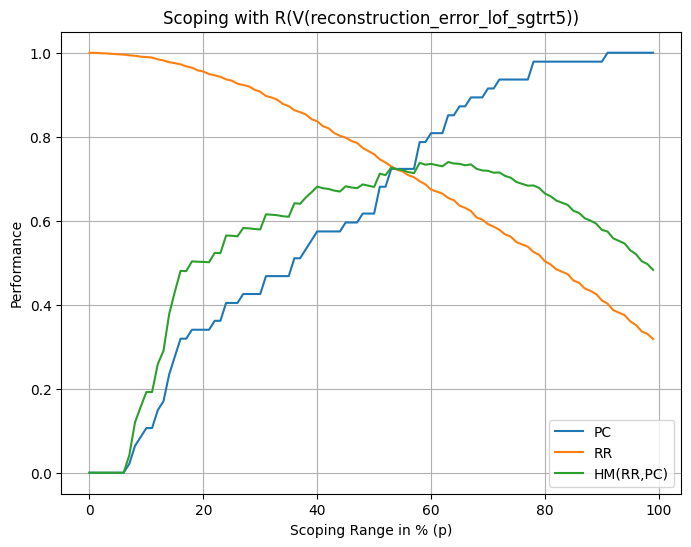

AUC PC (trapezoidal rule):  61.58510638297872
AUC HM (trapezoidal rule):  55.40702916244529


['reconstruction_error_lof_sgtrt5', 61.58510638297872, 55.40702916244529]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_lof_sgtrt5", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

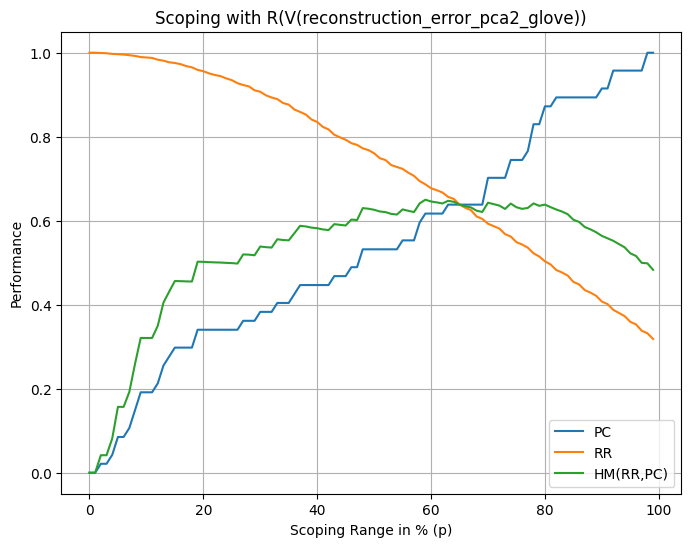

AUC PC (trapezoidal rule):  53.03191489361702
AUC HM (trapezoidal rule):  52.13229251097242


['reconstruction_error_pca2_glove', 53.03191489361702, 52.13229251097242]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_pca2_glove", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

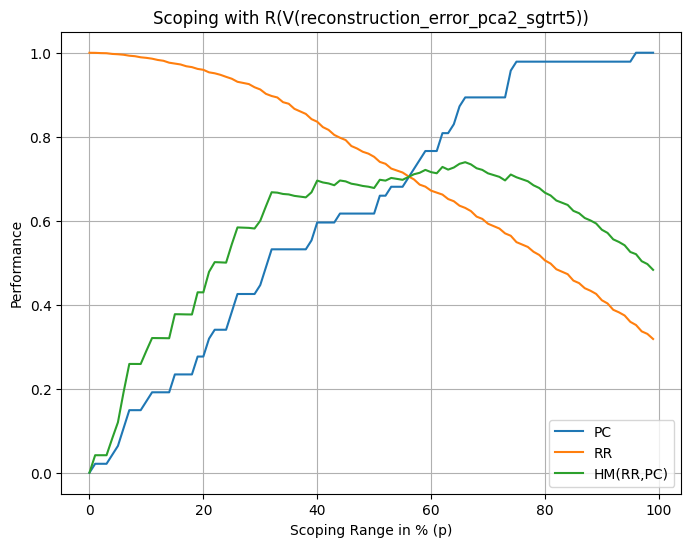

AUC PC (trapezoidal rule):  61.797872340425535
AUC HM (trapezoidal rule):  56.165229926725225


['reconstruction_error_pca2_sgtrt5', 61.797872340425535, 56.165229926725225]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_pca2_sgtrt5", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

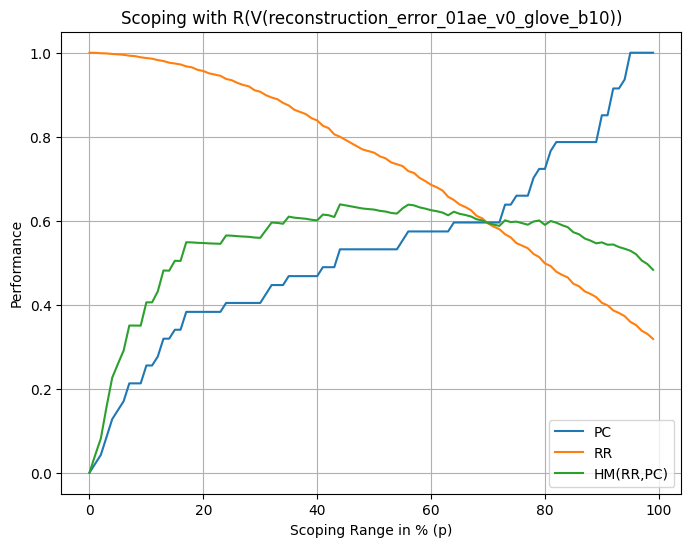

AUC PC (trapezoidal rule):  52.69148936170213
AUC HM (trapezoidal rule):  53.8351242077117


['reconstruction_error_01ae_v0_glove_b10', 52.69148936170213, 53.8351242077117]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_glove_b10", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

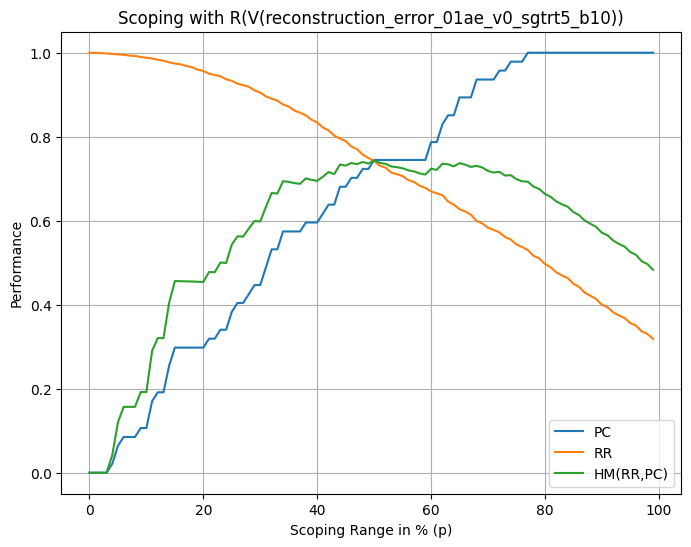

AUC PC (trapezoidal rule):  64.0531914893617
AUC HM (trapezoidal rule):  56.729516231142625


In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5_b10", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

##Ensemble

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
ensemble = df_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_glove","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_AHMb"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

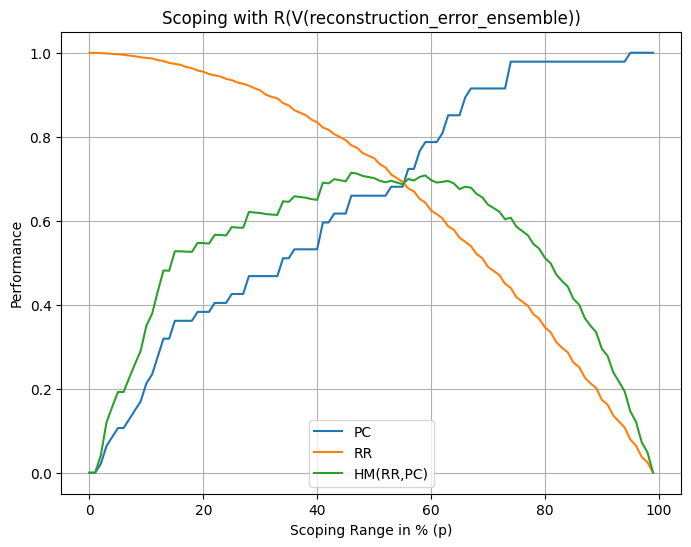

AUC PC (trapezoidal rule):  63.755319148936174
AUC HM (trapezoidal rule):  50.91910183000159


['reconstruction_error_ensemble', 63.755319148936174, 50.91910183000159]

In [ ]:
performance_plot(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_AHMb", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

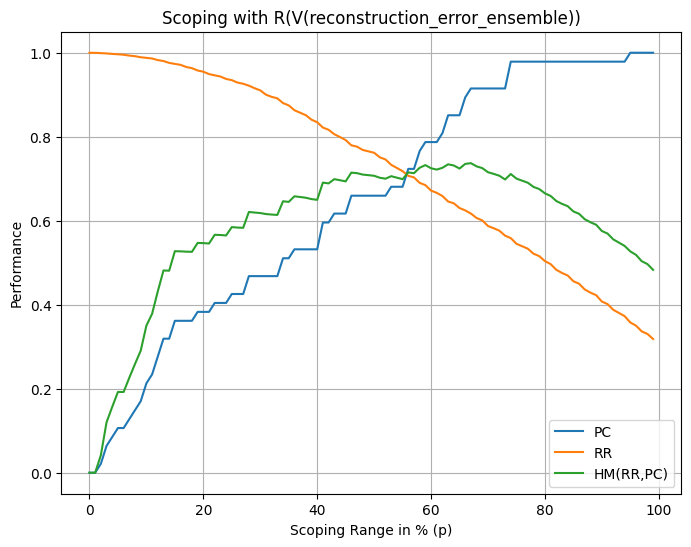

AUC PC (trapezoidal rule):  63.755319148936174
AUC HM (trapezoidal rule):  58.1052182463909


['reconstruction_error_ensemble', 63.755319148936174, 58.1052182463909]

In [ ]:
performance_plot_lsh(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_AHMb", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

In [ ]:
ensemble = df_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_sgtrt5","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_APC"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

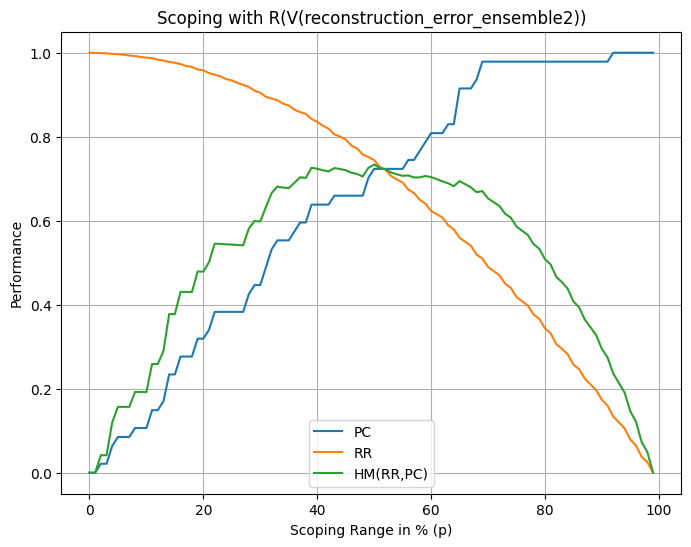

AUC PC (trapezoidal rule):  63.861702127659576
AUC HM (trapezoidal rule):  49.71412558537877


['reconstruction_error_ensemble2', 63.861702127659576, 49.71412558537877]

In [ ]:
performance_plot(df_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", gt_id_OC_ORACLE_OC_MYSQL_OC_HANA)

#2.3 Scoping Evaluation (domain-agnostic)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5"] = method_zscore(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"))
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_glove"] =  method_zscore(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"))
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_zscore_sgtrt5dc"] = method_zscore(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"))

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5"] = method_clf(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5"), min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_glove"] =  method_clf(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "300cc"), min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01lof_sgtrt5dc"] = method_clf(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "sgtrt5_dtype_constraint"), min_max_scale=True)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_glove"],_ = method_pca(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), 2, min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5"],_ = method_pca(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), 2, min_max_scale=True)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01pca2_sgtrt5dc"],_ = method_pca(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), 2, min_max_scale=True)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=10, bottleneck=10)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=10, bottleneck=10)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b10"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=10, bottleneck=10)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b25"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=10, bottleneck=25)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b25"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=10, bottleneck=25)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b25"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=10, bottleneck=25)

In [ ]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b50"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=10, bottleneck=50)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b50"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=10, bottleneck=50)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b50"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=10, bottleneck=50)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_glove_b100"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "300cc"), max_iter=10, bottleneck=100)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5_b100"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5"), max_iter=10, bottleneck=100)
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_01ae_v0_sgtrt5dc_b100"] = method_ae_v0(concept_embeddings_to_ce_x(ce_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA , "sgtrt5_dtype_constraint"), max_iter=10, bottleneck=100)

In [ ]:
#df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.to_csv("/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.csv", index=False)

In [47]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = pd.read_csv(r'/content/drive/MyDrive/SS23 PhD/SP23 Independent Study (Leo)/Datasets/df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.csv')

In [48]:
# GROUND TRUTH ORDERING CUSTOMER
gt_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = []

for index, row in df_gt_mappings[(df_gt_mappings["Type"] == "Attribute")].iterrows():
    gt_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].refined_local_name.item(),
                                                    df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].refined_local_name.item()))

In [49]:
# GROUND TRUTH ORDERING CUSTOMER
gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA = []

for index, row in df_gt_mappings[(df_gt_mappings["Type"] == "Attribute")].iterrows():
    gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.append((df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_A']].id.item(),
                                                       df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["id"]==row['Attribute_B']].id.item()))

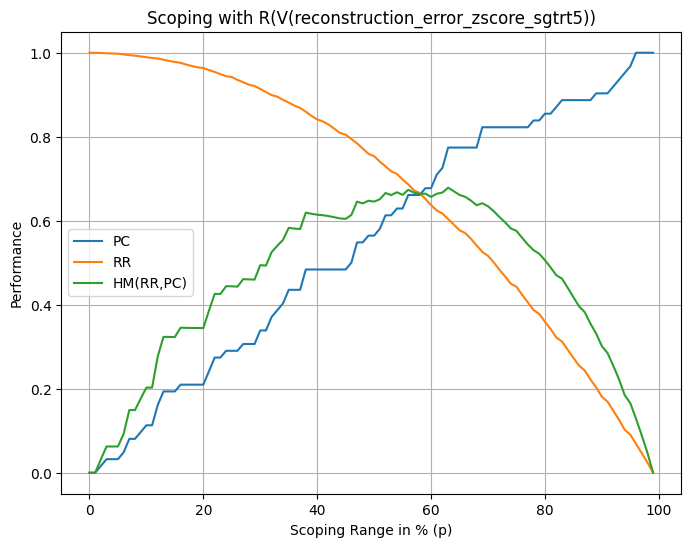

AUC PC (trapezoidal rule):  54.20967741935483
AUC HM (trapezoidal rule):  44.81237377128327


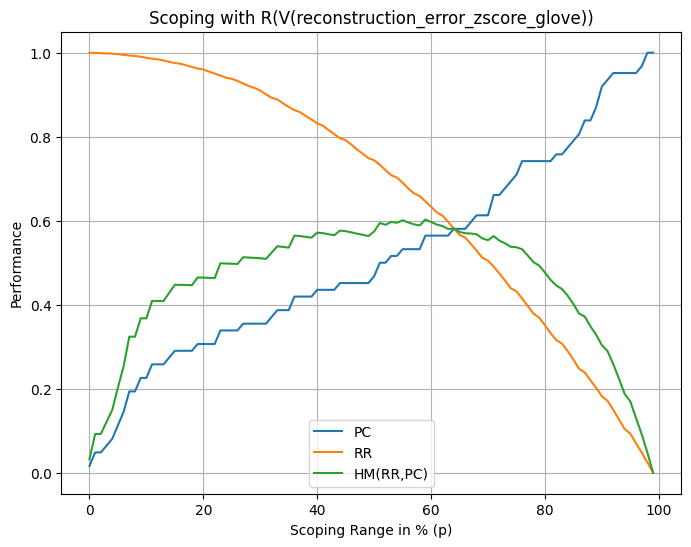

AUC PC (trapezoidal rule):  50.57258064516129
AUC HM (trapezoidal rule):  45.05666889092153


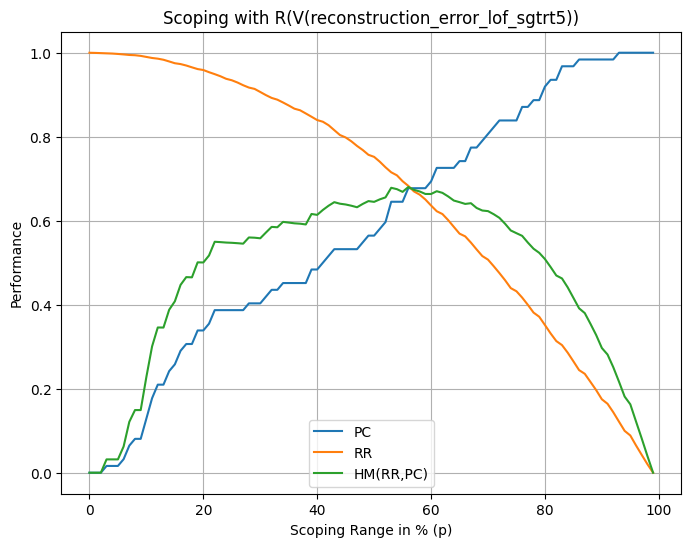

AUC PC (trapezoidal rule):  57.69354838709677
AUC HM (trapezoidal rule):  46.91476631717662


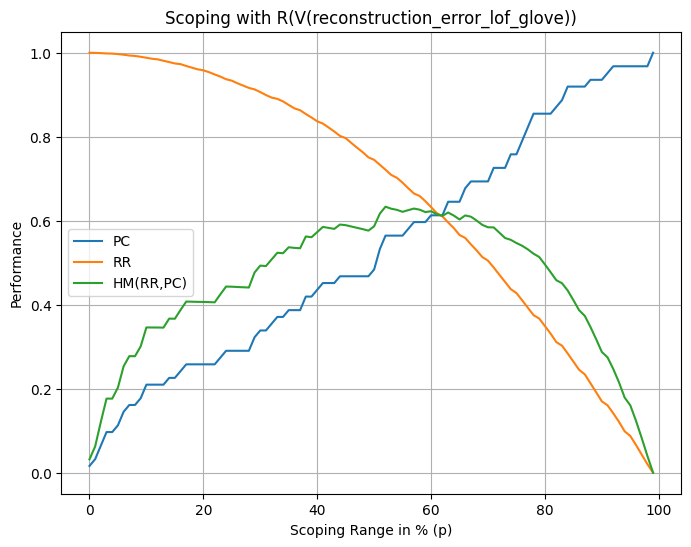

AUC PC (trapezoidal rule):  52.62096774193549
AUC HM (trapezoidal rule):  44.5992381630758


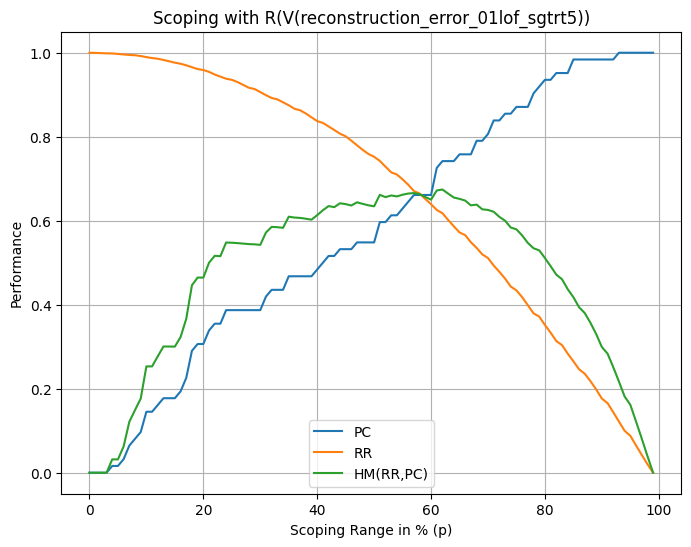

AUC PC (trapezoidal rule):  57.11290322580645
AUC HM (trapezoidal rule):  46.157600710834494


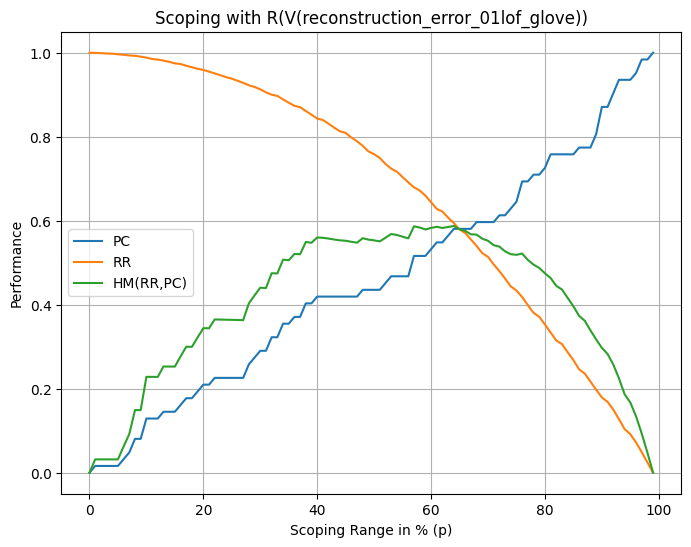

AUC PC (trapezoidal rule):  45.33870967741935
AUC HM (trapezoidal rule):  39.846020583209636


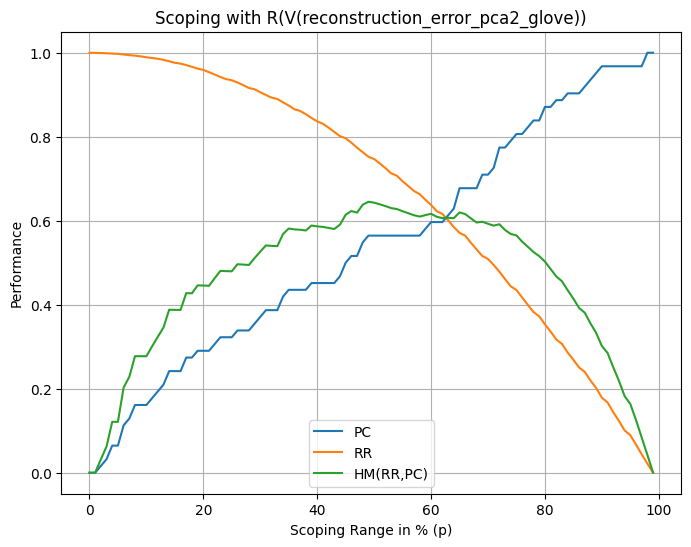

AUC PC (trapezoidal rule):  53.612903225806456
AUC HM (trapezoidal rule):  45.331885264163695


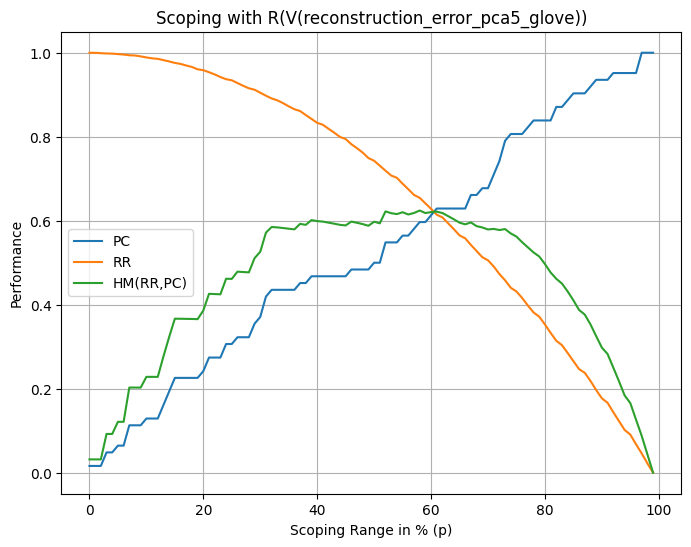

AUC PC (trapezoidal rule):  52.33064516129033
AUC HM (trapezoidal rule):  44.06627798481939


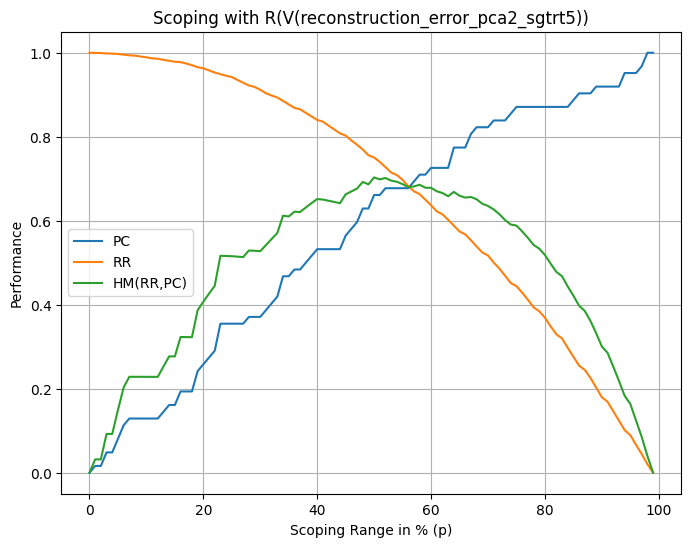

AUC PC (trapezoidal rule):  56.806451612903224
AUC HM (trapezoidal rule):  46.93753561810301


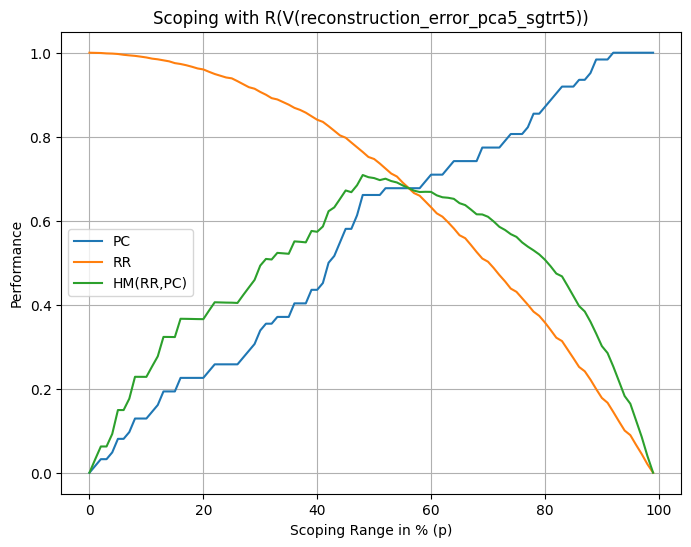

AUC PC (trapezoidal rule):  55.403225806451616
AUC HM (trapezoidal rule):  45.128897341530916


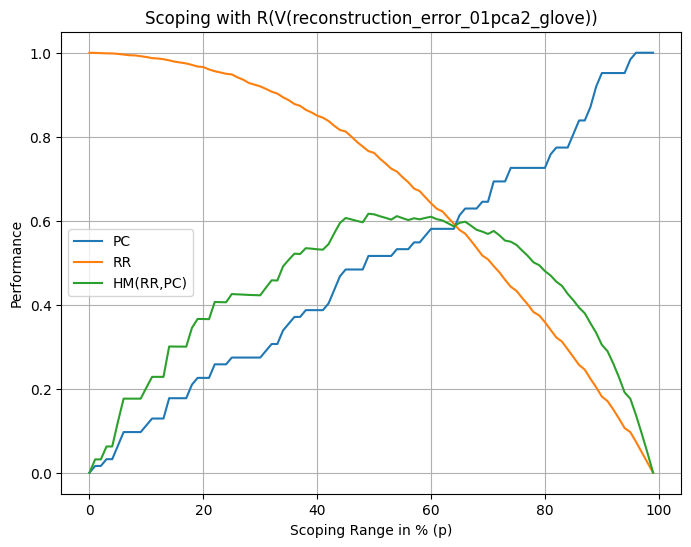

AUC PC (trapezoidal rule):  48.48387096774193
AUC HM (trapezoidal rule):  41.833745251881716


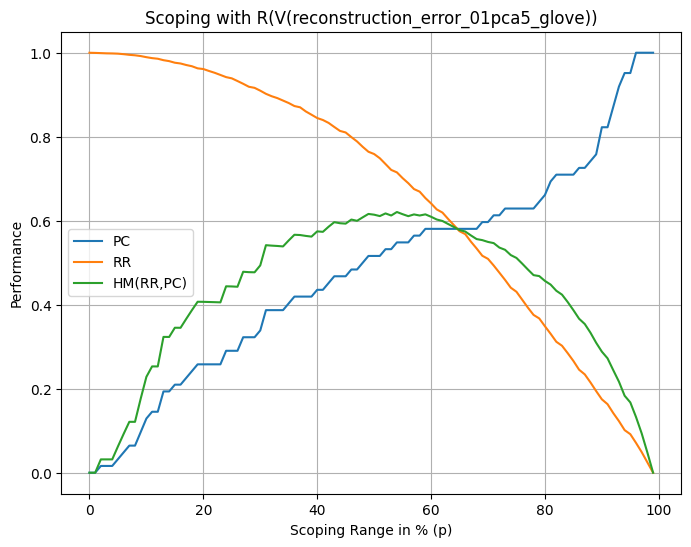

AUC PC (trapezoidal rule):  47.354838709677416
AUC HM (trapezoidal rule):  42.339296928384684


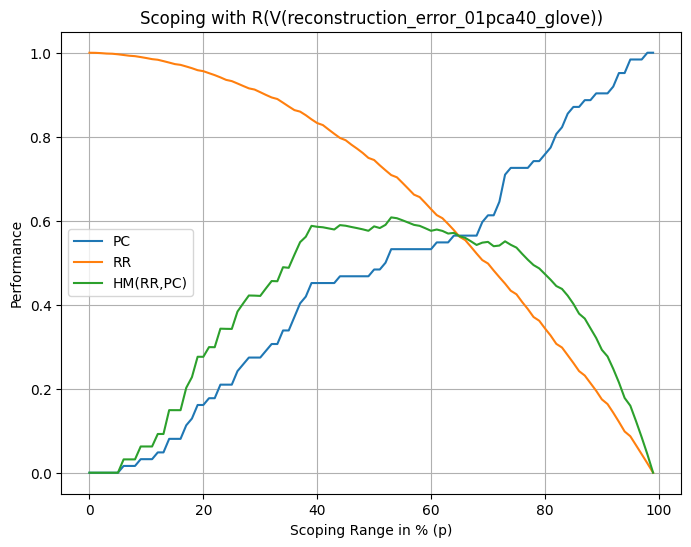

AUC PC (trapezoidal rule):  46.46774193548387
AUC HM (trapezoidal rule):  38.452255523984654


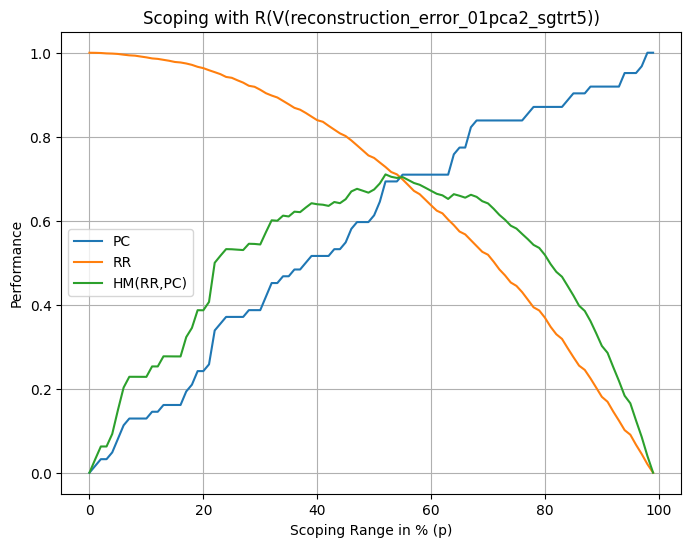

AUC PC (trapezoidal rule):  56.9516129032258
AUC HM (trapezoidal rule):  47.137888994749545


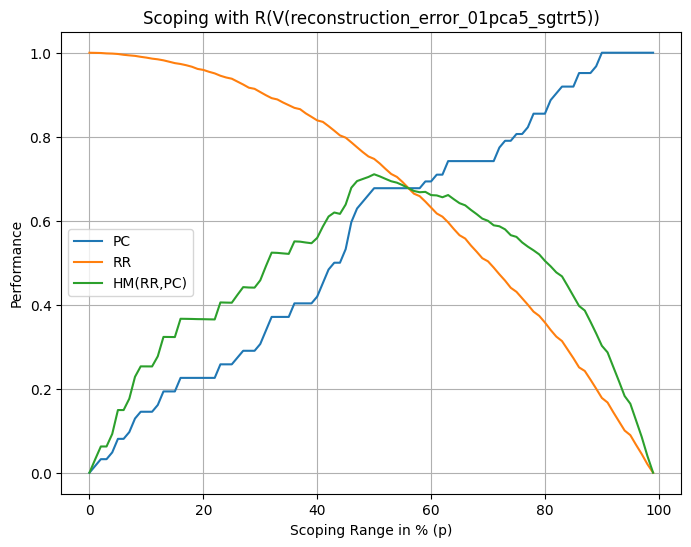

AUC PC (trapezoidal rule):  55.16129032258064
AUC HM (trapezoidal rule):  44.96238805788987


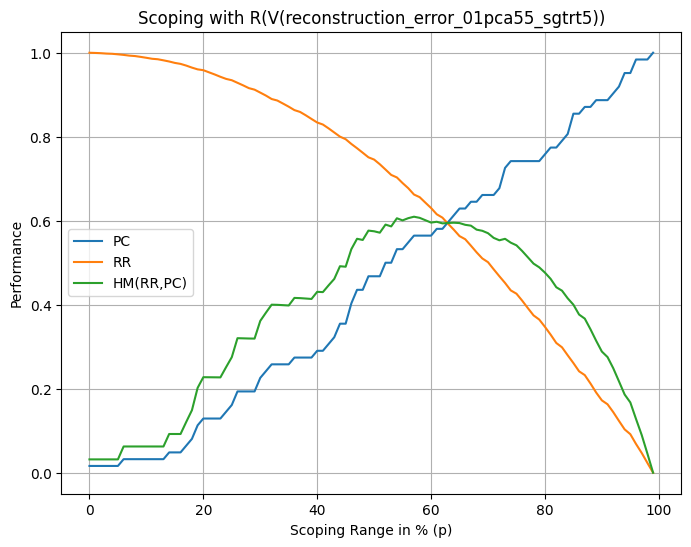

AUC PC (trapezoidal rule):  44.362903225806456
AUC HM (trapezoidal rule):  35.99793301029446


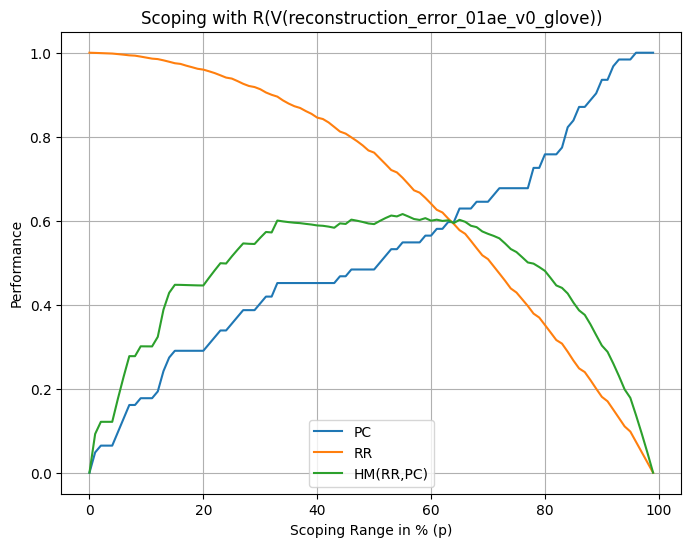

AUC PC (trapezoidal rule):  51.82258064516129
AUC HM (trapezoidal rule):  45.70038805941898


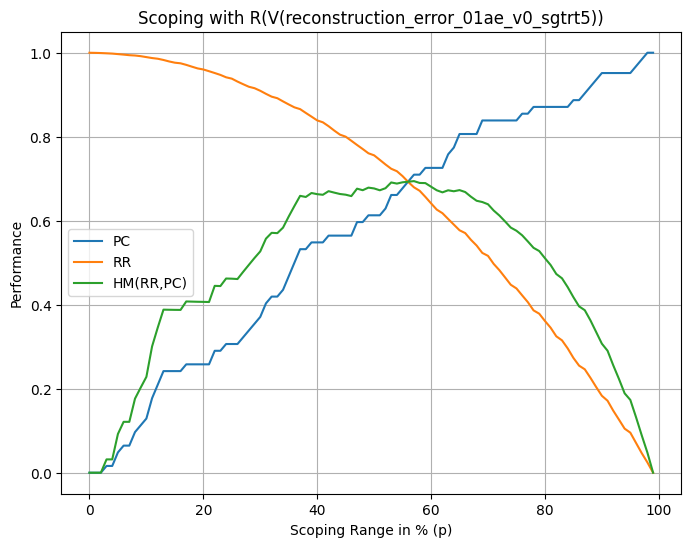

AUC PC (trapezoidal rule):  57.06451612903226
AUC HM (trapezoidal rule):  47.03164769753019


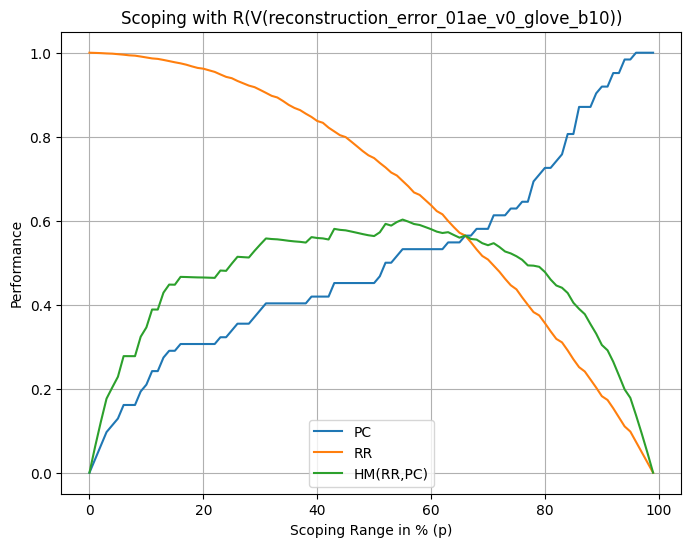

AUC PC (trapezoidal rule):  49.96774193548387
AUC HM (trapezoidal rule):  44.95195298802958


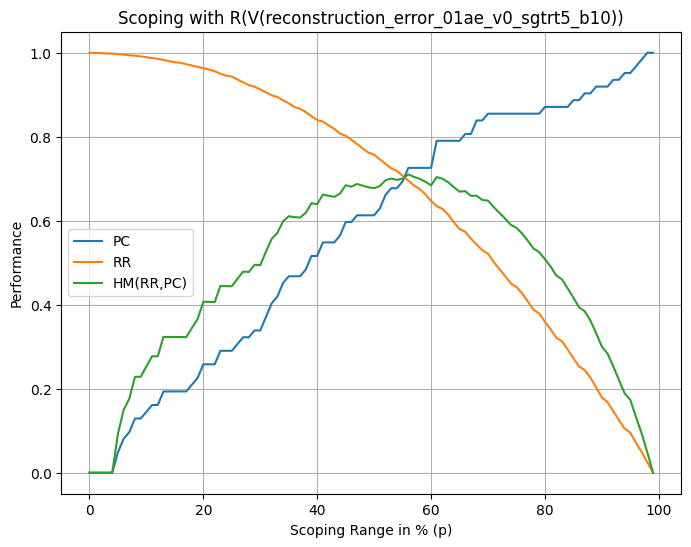

AUC PC (trapezoidal rule):  56.7258064516129
AUC HM (trapezoidal rule):  46.54689995479275


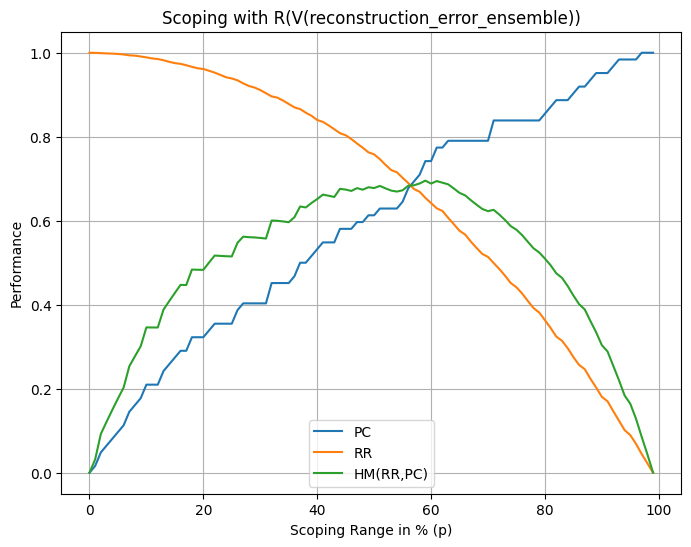

AUC PC (trapezoidal rule):  58.612903225806456
AUC HM (trapezoidal rule):  48.968698068208816


Setting  AUC_PC_trapezoidal  \
0        reconstruction_error_zscore_sgtrt5           54.209677   
1         reconstruction_error_zscore_glove           50.572581   
2           reconstruction_error_lof_sgtrt5           57.693548   
3            reconstruction_error_lof_glove           52.620968   
4         reconstruction_error_01lof_sgtrt5           57.112903   
5          reconstruction_error_01lof_glove           45.338710   
6           reconstruction_error_pca2_glove           53.612903   
7           reconstruction_error_pca5_glove           52.330645   
8          reconstruction_error_pca2_sgtrt5           56.806452   
9          reconstruction_error_pca5_sgtrt5           55.403226   
10        reconstruction_error_01pca2_glove           48.483871   
11        reconstruction_error_01pca5_glove           47.354839   
12       reconstruction_error_01pca40_glove           46.467742   
13       reconstruction_error_01pca2_sgtrt5           56.951613   
14       reconstruction_error_01pca5_sgtrt5           55.161290   
15      reconstruction_error_01pca55_sgtrt5           44.362903   
16       reconstruction_error_01ae_v0_glove           51.822581   
17      reconstruction_error_01ae_v0_sgtrt5           57.064516   
18   reconstruction_error_01ae_v0_glove_b10           49.967742   
19  reconstruction_error_01ae_v0_sgtrt5_b10           56.725806   
20            reconstruction_error_ensemble           58.612903   

    AUC_HM_trapezoidal  
0            44.812374  
1            45.056669  
2            46.914766  
3            44.599238  
4            46.157601  
5            39.846021  
6            45.331885  
7            44.066278  
8            46.937536  
9            45.128897  
10           41.833745  
11           42.339297  
12           38.452256  
13           47.137889  
14           44.962388  
15           35.997933  
16           45.700388  
17           47.031648  
18           44.951953  
19           46.546900  
20           48.968698

In [ ]:
auc = []
for eval_col in df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns[df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns.str.contains("reconstruction_error")]:
  auc.append(performance_plot(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

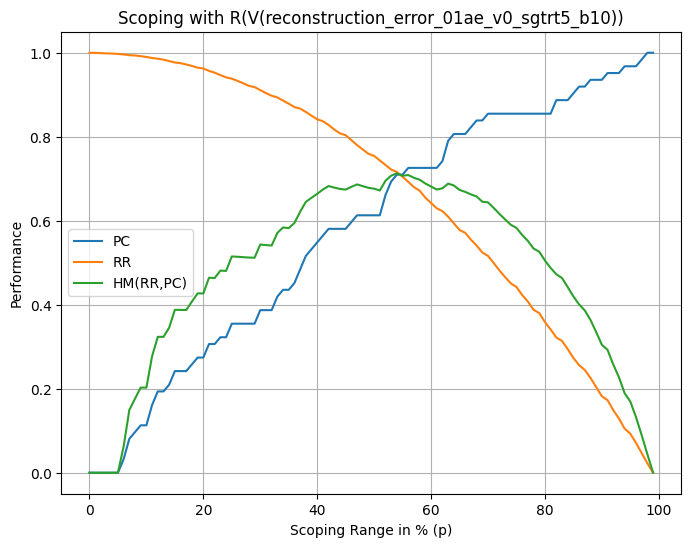

AUC PC (trapezoidal rule):  57.58064516129032
AUC HM (trapezoidal rule):  47.1089042636014


Setting  AUC_PC_trapezoidal  \
0  reconstruction_error_01ae_v0_sgtrt5_b10           57.580645   

   AUC_HM_trapezoidal  
0           47.108904

In [ ]:
auc = []
for eval_col in ["reconstruction_error_01ae_v0_sgtrt5_b10"]:
  auc.append(performance_plot(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, eval_col, gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA))
pd.DataFrame(auc, columns=["Setting", "AUC_PC_trapezoidal", "AUC_HM_trapezoidal"])

##Ensemble

In [ ]:
ensemble = df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_glove","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_APC"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

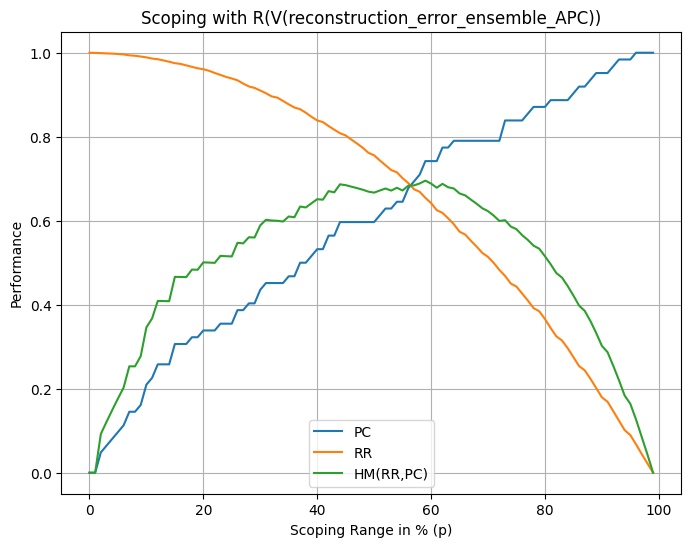

AUC PC (trapezoidal rule):  58.806451612903224
AUC HM (trapezoidal rule):  49.12560418463047


['reconstruction_error_ensemble_APC', 58.806451612903224, 49.12560418463047]

In [ ]:
performance_plot(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_APC", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

In [ ]:
ensemble = df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA[["reconstruction_error_zscore_sgtrt5","reconstruction_error_lof_sgtrt5","reconstruction_error_pca2_sgtrt5","reconstruction_error_01ae_v0_sgtrt5_b10"]].copy()
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA["reconstruction_error_ensemble_AHMb"] = pd.DataFrame(scaler.fit_transform(ensemble), columns=ensemble.columns).mean(axis=1)

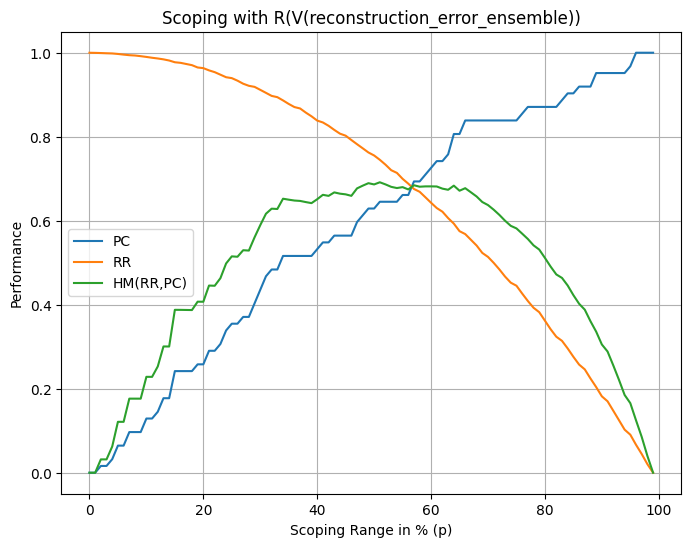

AUC PC (trapezoidal rule):  57.806451612903224
AUC HM (trapezoidal rule):  47.4469268914215


['reconstruction_error_ensemble', 57.806451612903224, 47.4469268914215]

In [ ]:
performance_plot(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_AHMb", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

##LSH

In [51]:
df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA.columns

Index(['id', 'refined_local_name', 'parent_id', 'refined_local_name_p',
       'schema', 'vec_datatype_numeric', 'vec_datatype_text',
       'vec_datatype_date', 'vec_datatype_miscellaneous', 'vec_constraint_pk',
       'vec_constraint_fk', 'vec_constraint_notnull', 'vec_constraint_default',
       'vec_constraint_unique', 'vec_constaint_check', 'concept_concat_info',
       'concept_concat_sgtrt5', 'concept_concat_sgtrt5_dtype_constraints',
       'reconstruction_error_zscore_sgtrt5',
       'reconstruction_error_zscore_glove', 'reconstruction_error_lof_sgtrt5',
       'reconstruction_error_lof_glove', 'reconstruction_error_01lof_sgtrt5',
       'reconstruction_error_01lof_glove', 'reconstruction_error_pca2_glove',
       'reconstruction_error_pca5_glove', 'reconstruction_error_pca2_sgtrt5',
       'reconstruction_error_pca5_sgtrt5', 'reconstruction_error_01pca2_glove',
       'reconstruction_error_01pca5_glove',
       'reconstruction_error_01pca40_glove',
       'reconstruction_erro

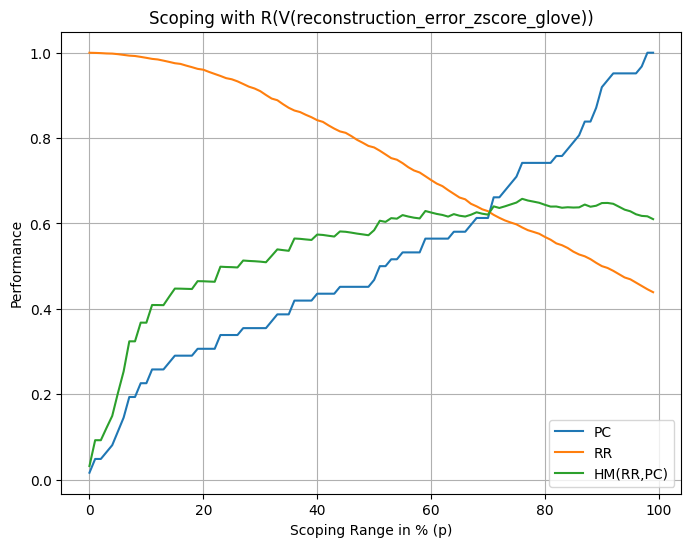

AUC PC (trapezoidal rule):  50.57258064516129
AUC HM (trapezoidal rule):  53.46231640598048


['reconstruction_error_zscore_glove', 50.57258064516129, 53.46231640598048]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_zscore_glove", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

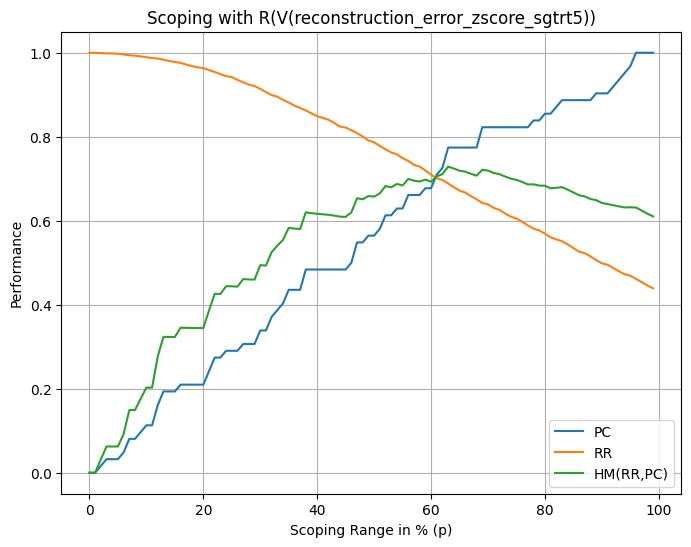

AUC PC (trapezoidal rule):  54.20967741935483
AUC HM (trapezoidal rule):  53.61285623135502


['reconstruction_error_zscore_sgtrt5', 54.20967741935483, 53.61285623135502]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_zscore_sgtrt5", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

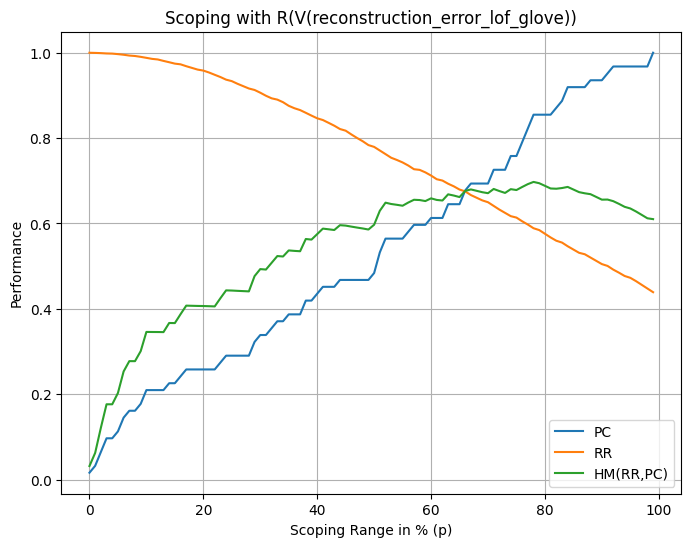

AUC PC (trapezoidal rule):  52.62096774193549
AUC HM (trapezoidal rule):  53.815696277179484


['reconstruction_error_lof_glove', 52.62096774193549, 53.815696277179484]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_lof_glove", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

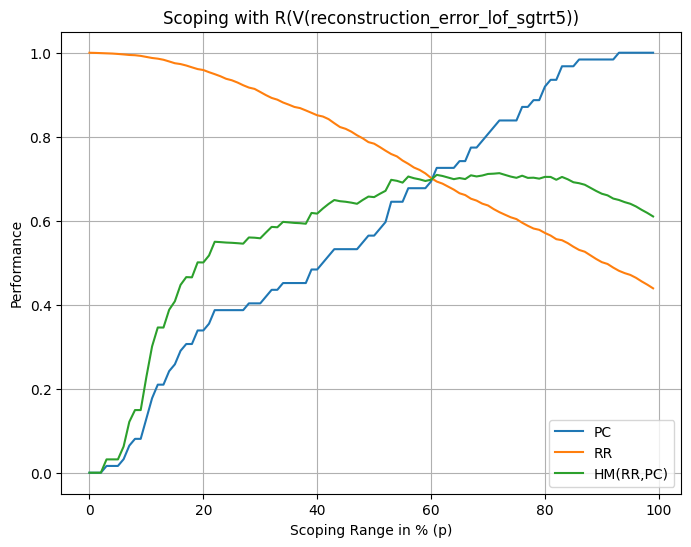

AUC PC (trapezoidal rule):  57.69354838709677
AUC HM (trapezoidal rule):  56.20295760210317


['reconstruction_error_lof_sgtrt5', 57.69354838709677, 56.20295760210317]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_lof_sgtrt5", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

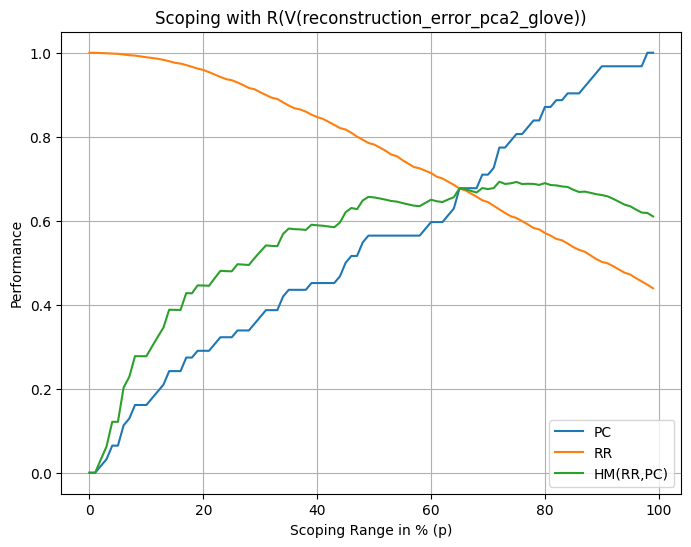

AUC PC (trapezoidal rule):  53.612903225806456
AUC HM (trapezoidal rule):  54.32126011839165


['reconstruction_error_pca2_glove', 53.612903225806456, 54.32126011839165]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_pca2_glove", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

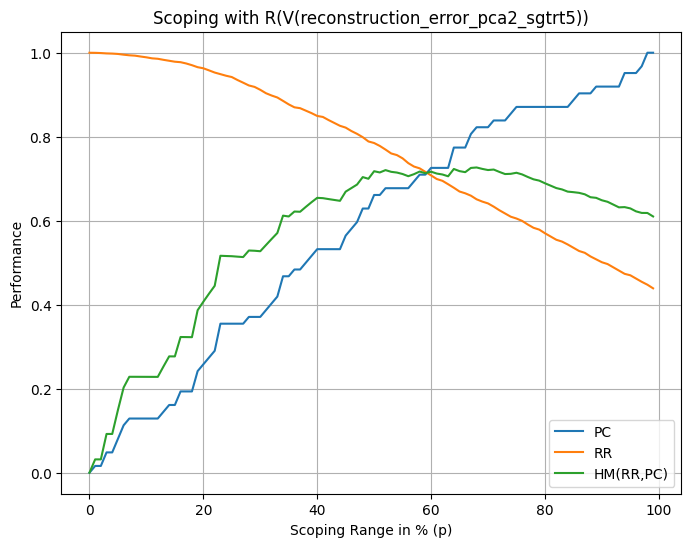

AUC PC (trapezoidal rule):  56.806451612903224
AUC HM (trapezoidal rule):  55.793405794508764


['reconstruction_error_pca2_sgtrt5', 56.806451612903224, 55.793405794508764]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_pca2_sgtrt5", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

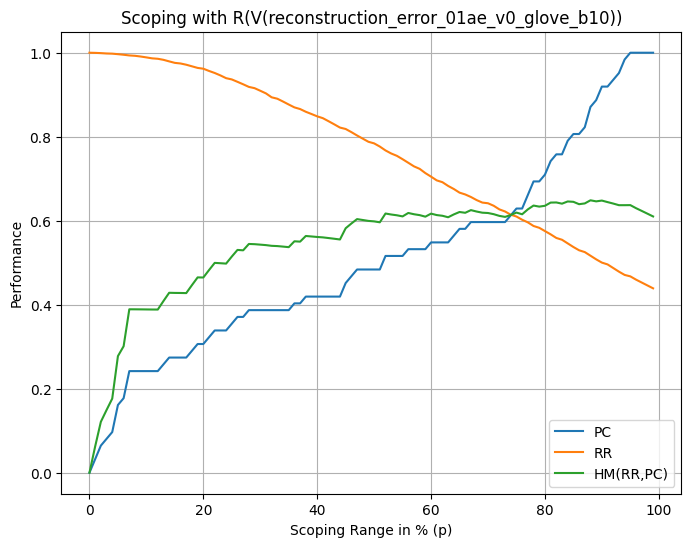

AUC PC (trapezoidal rule):  50.306451612903224
AUC HM (trapezoidal rule):  53.72787178661314


['reconstruction_error_01ae_v0_glove_b10',
 50.306451612903224,
 53.72787178661314]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_glove_b10", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

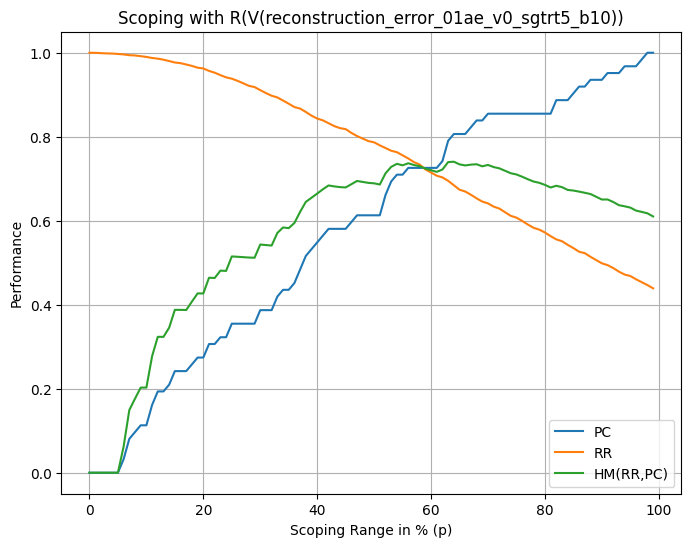

AUC PC (trapezoidal rule):  57.58064516129032
AUC HM (trapezoidal rule):  56.019609816145106


['reconstruction_error_01ae_v0_sgtrt5_b10',
 57.58064516129032,
 56.019609816145106]

In [ ]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_01ae_v0_sgtrt5_b10", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)

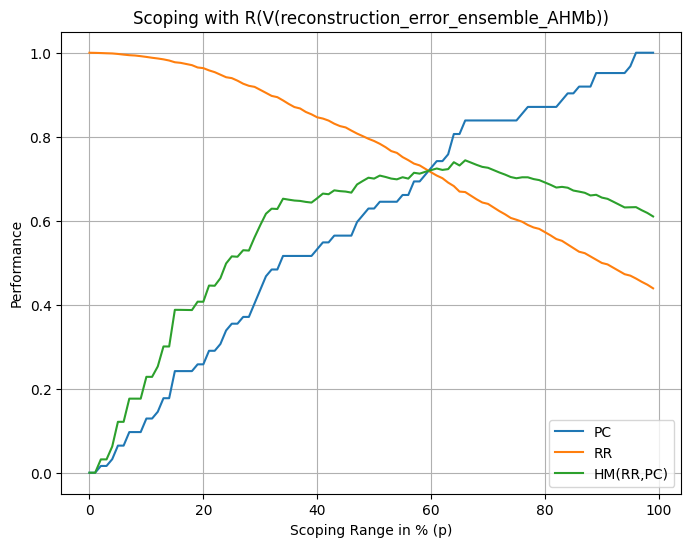

AUC PC (trapezoidal rule):  57.806451612903224
AUC HM (trapezoidal rule):  56.38487190436282


['reconstruction_error_ensemble_AHMb', 57.806451612903224, 56.38487190436282]

In [52]:
performance_plot_lsh(df_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA, "reconstruction_error_ensemble_AHMb", gt_id_HR_ORACLE_OC_ORACLE_OC_MYSQL_OC_HANA)